

**Electricity Price Forecasting with Deep Neural Networks**

Electricity is a vital resource and has become a tradeable commodity following market deregulation in many countries, including Spain after the Electric Power Act 54/1997. This introduced high price volatility, creating a strong need for accurate electricity price forecasting at various time scales.

This project aims to predict the next hour's electricity price using past values of electricity prices along with energy generation and weather-related features. It involves thorough data cleaning, time series analysis, and feature engineering.

Several deep learning models are compared—LSTM, stacked LSTM, CNN, CNN-LSTM, Time Distributed MLP, and Encoder-Decoder—as well as the XGBoost regressor. These models are evaluated for multivariate forecasting using 25 previous time steps, with features reduced via PCA. The Adam optimizer is used, with initial learning rate tuning performed using a scheduler (though omitted in this version). Model performance is assessed using Root Mean Squared Error (RMSE).

This end-to-end project showcases a real-world application of time series forecasting and serves as a comprehensive reference for data science practitioners in the energy sector.



**Table of Contents**
1. Exploration and Cleaning

1.1. Energy dataset

1.2. Weather features dataset

1.3. Merging the two datasets

2. Visualizations and Time Series Analysis

2.1. Useful visualizations and insights

2.2. Decomposition and stationarity tests

2.3. Autocorrelation, partial autocorrelation and cross-correlation

3. Feature Engineering

3.1. Feature generation

3.2. Feature selection

4. Electricity Price Forecasting

4.1. Naive forecast

4.2. XGBoost

4.3. LSTM

4.4. Stacked LSTMs

4.5. CNN

4.6. CNN-LSTM

4.7. Time Disitributed MLP

4.8. Encoder-Decoder

5. Results
6. References


**1. Exploration and Cleaning**



The dataset includes two CSV files with hourly data from 2015 to 2019:

- **weather_features.csv**: Contains weather data (temperature, wind speed, humidity, rainfall, and conditions) for five major Spanish cities—Madrid, Barcelona, Valencia, Seville, and Bilbao.
- **energy_dataset.csv**: Includes electricity generation data by source (e.g., fossil gas, hard coal, wind), national grid demand, and electricity price (€/MWh). Since the data is hourly and measured in MW, values represent MWh.

These five cities, covering diverse regions and about one-third of Spain’s population, provide sufficient geographic and demographic representation for the analysis.



In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt


In [4]:
df_weather = pd.read_csv(
    '/content/weather_features.csv',
    parse_dates=['dt_iso']
)


df_energy = pd.read_csv(
    '/content/energy_dataset.csv',
    parse_dates=['time'])

**1.1. Energy dataset**

In [5]:
df_energy.head()


time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable. We will also remove the columns which will not be used at all in our analysis and which contain day-ahead forecasts for the total load, the solar energy and the wind energy.



In [6]:
df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)


In [7]:
df_energy.describe().round(2)


generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil gas  generation fossil hard coal  \
count               35046.00                     35046.00   
mean                 5622.74                      4256.07   
std                  2201.83                      1961.60   
min                     0.00                         0.00   
25%                  4126.00                      2527.00   
50%                  4969.00                      4474.00   
75%                  6429.00                      5838.75   
max                 20034.00                      8359.00   

       generation fossil oil  generation hydro pumped storage consumption  \
count               35045.00                                     35045.00   
mean                  298.32                                       475.58   
std                    52.52                                       792.41   
min                     0.00                                         0.00   
25%                   263.00                                         0.00   
50%                   300.00                                        68.00   
75%                   330.00                                       616.00   
max                   449.00                                      4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water reservoir  generation nuclear  generation other  \
count                          35046.00            35047.00          35046.00   
mean                            2605.11             6263.91             60.23   
std                             1835.20              839.67             20.24   
min                                0.00                0.00              0.00   
25%                             1077.25             5760.00             53.00   
50%                             2164.00             6566.00             57.00   
75%                             3757.00             7025.00             80.00   
max                             9728.00             7117.00            106.00   

       generation other renewable  generation solar  generation waste  \
count                    35046.00          35046.00          35045.00   
mean                        85.64           1432.67            269.45   
std                         14.08           1680.12             50.20   
min                          0.00              0.00              0.00   
25%                         73.00             71.00            240.00   
50%                         88.00            616.00            279.00   
75%                         97.00           2578.00            310.00   
max                        119.00           5792.00            357.00   

       generation wind onshore  total load actual  price day ahead  \
count                 35046.00           35028.00         35064.00   
mean                   5464.48           28696.94            49.87   
std                    3213.69            4574.99            14.62   
min          

In [8]:
df_energy.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

The 'time' column, which we also want to function as the index of the observations in a time-series, has not been parsed correctly and is recognized as an object.



In [9]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')


<ipython-input-9-fc44ba1f0c77>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)


In [10]:
print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))


There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


As we can see, df_energy has no duplicate values. Nevertheless, it has some NaNs and thus, we have to investigate further. Since this is a time-series forecasting task, we cannot simply drop the rows with the missing values and it would be a better idea to fill the missing values using interpolation.



In [11]:
df_energy.isnull().sum(axis=0)


generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Most null values can be found in the 'total load actual' column. Therefore, it is a good idea to visualize it and see what we can do. The good news is that there are no NaNs in the 'price actual' column, which we will use as the target variable in order to train our model. The similar numbers in null values in the columns which have to do with the type of energy generation probably indicate that they will also appear in the same rows. Let us first define a plot function which we will then use so as to visualize the 'total load actual' column, as well as other columns

In [12]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series
    created by the user. The user can define either the 'df' and the 'column'
    or the 'series' and additionally, can also define the 'label', the
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax



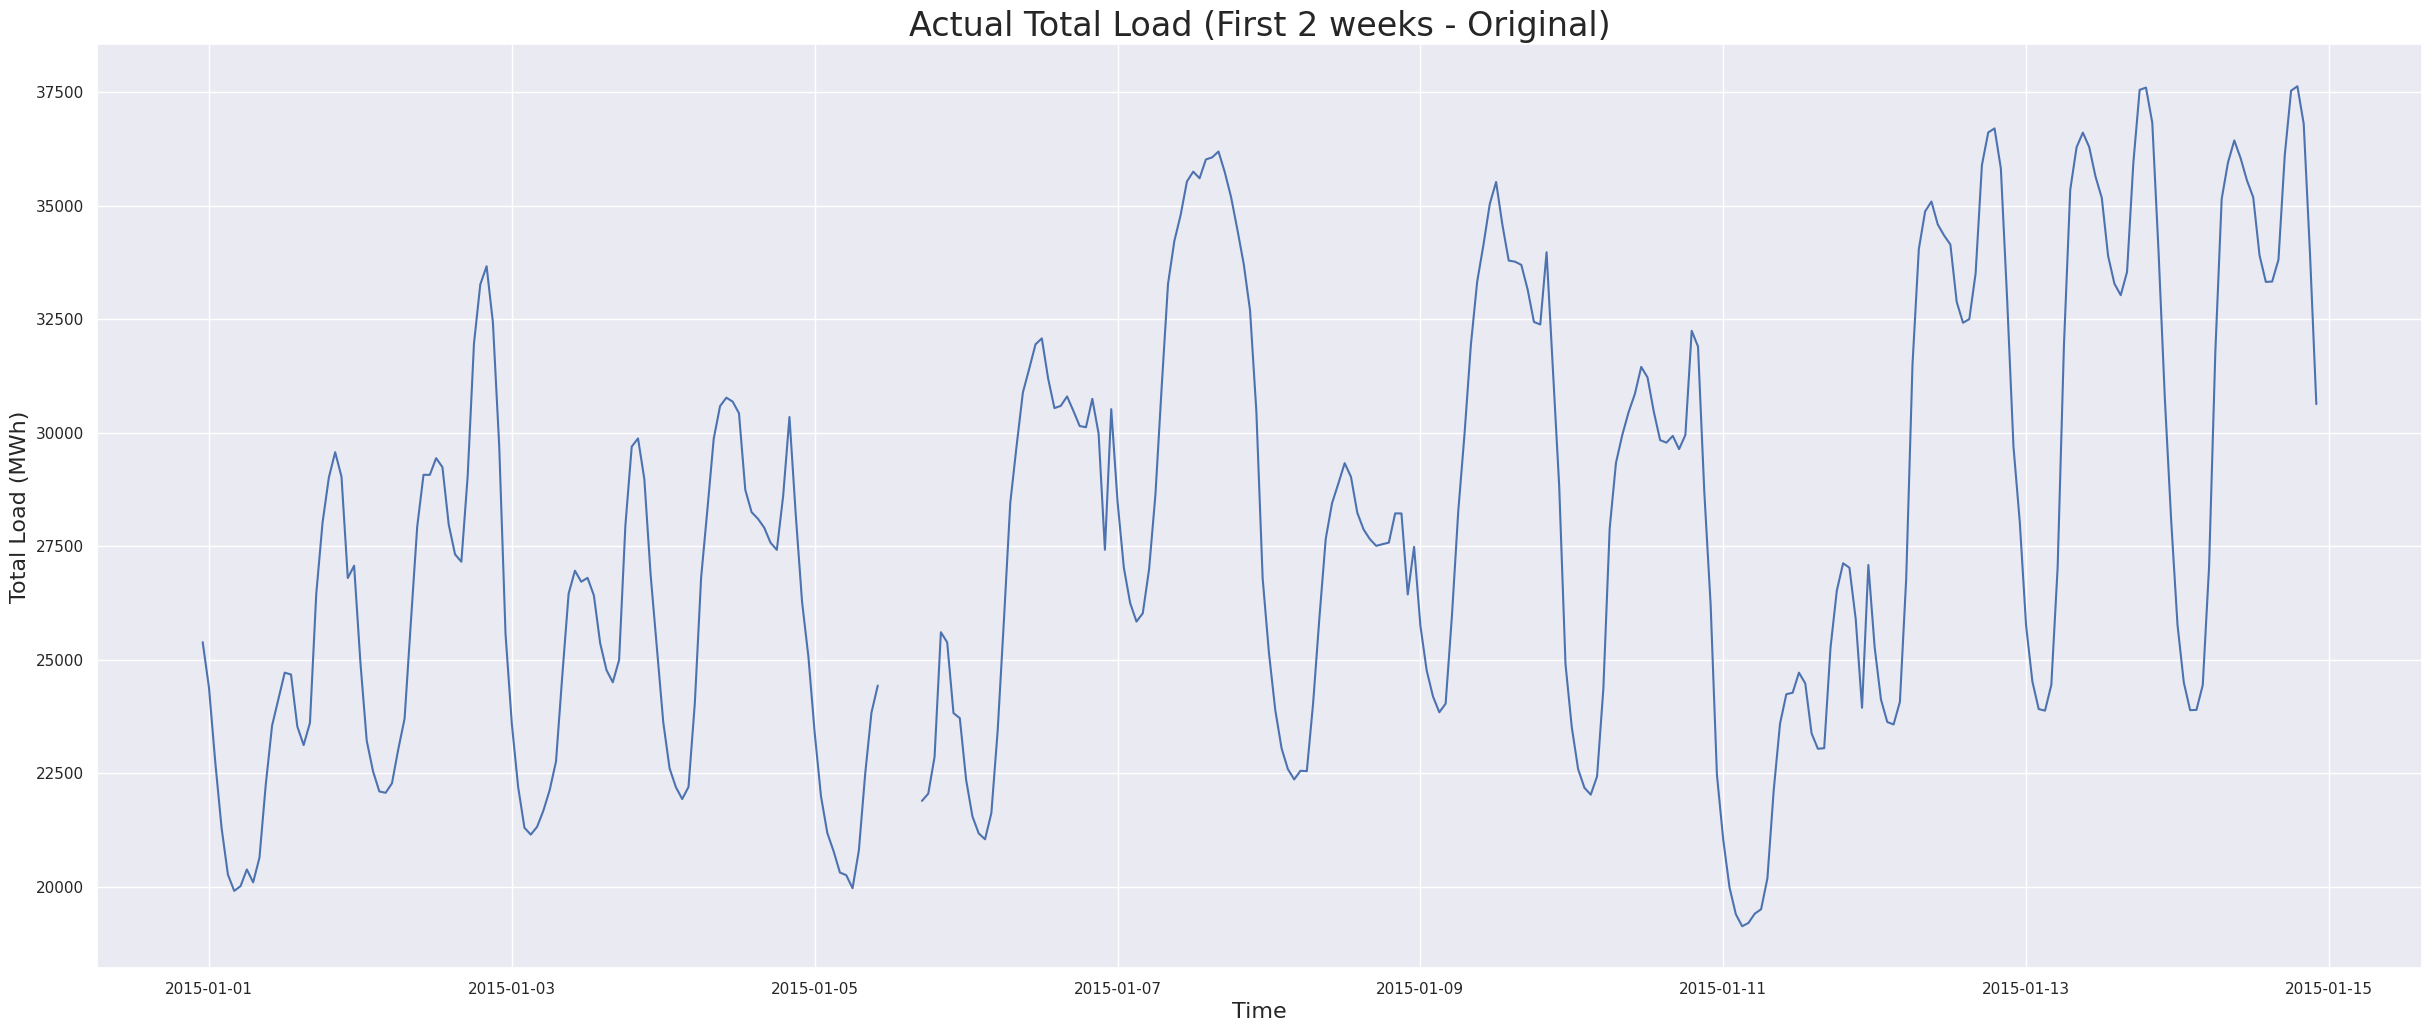

In [13]:
ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()


After zooming into the first 2 weeks of the 'total load actual' column, we can already see that there are null values for a few hours. However, the number of the missing values and the behavior of the series indicate that an interpolation would fill the NaNs quite well. Let us further investigate if the null values coincide across the different columns. Let us display the last five rows.



In [14]:
df_energy[df_energy.isnull().any(axis=1)].tail()


generation biomass  \
time                                            
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2016-11-23 03:00:00+00:00                                 900.0   
2017-11-14 11:00:00+00:00                                   0.0   
2017-11-14 18:00:00+00:00                                   0.0   
2018-06-11 16:00:00+00:00                                 506.0   
2018-07-11 07:00:00+00:00                                   NaN   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2016-11-23 03:00:00+00:00                 4838.0                       4547.0   
2017-11-14 11:00:00+00:00                10064.0                          0.0   
2017-11-14 18:00:00+00:00                12336.0                          0.0   
2018-06-11 16:00:00+00:00                 7538.0                       5360.0   
2018-07-11 07:00:00+00:00                    NaN                          NaN   

                           generation fossil oil  \
time                                               
2016-11-23 03:00:00+00:00                  269.0   
2017-11-14 11:00:00+00:00                    0.0   
2017-11-14 18:00:00+00:00                    0.0   
2018-06-11 16:00:00+00:00                  300.0   
2018-07-11 07:00:00+00:00                    NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2016-11-23 03:00:00+00:00                                       1413.0   
2017-11-14 11:00:00+00:00                                          0.0   
2017-11-14 18:00:00+00:00                                          0.0   
2018-06-11 16:00:00+00:00                                          1.0   
2018-07-11 07:00:00+00:00                                          NaN   

                           generation hydro run-of-river and poundage  \
time                                                                    
2016-11-23 03:00:00+00:00                                       795.0   
2017-11-14 11:00:00+00:00                                         0.0   
2017-11-14 18:00:00+00:00                                         0.0   
2018-06-11 16:00:00+00:00                                      1134.0   
2018-07-11 07:00:00+00:00                                         NaN   

                           generation hydro water reservoir  \
time                                                          
2016-11-23 03:00:00+00:00                             435.0   
2017-11-14 11:00:00+00:00                               0.0   
2017-11-14 18:00:00+00:00                               0.0   
2018-06-11 16:00:00+00:00                            4258.0   
2018-07-11 07:00:00+00:00                               NaN   

                           generation nuclear  generation other  \
time                                                              
2016-11-23 03:00:00+00:00              5040.0              60.0   
2017-11-14 11:00:00+00:00                 0.0               0.0   
2017-11-14 18:00:00+00:00                 0.0               0.0   
2018-06-11 16:00:00+00:00              5856.0              52.0   
2018-07-11 07:00:00+00:00                 NaN               NaN   

                           generation other renewable  generation solar  \
time                                                                      
2016-11-23 03:00:00+00:00                        85.0              15.0   
2017-11-14 11:00:00+00:00                         0.0               0.0   
2017-11-14 18:00:00+00:00            

If we manually searched through all of them, we would confirm that the null values in the columns which have to do with the type of energy generation mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well. In order to handle the null values in df_energy, we will use a linear interpolation with a forward direction. Perhaps other kinds of interpolation would be better; nevertheless, we prefer to use the simplest model possible. Only a small part of our input data will be noisy and it will not affect performance noticeably.



In [15]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [16]:
print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


It look like df_energy has been cleaned successfully and is ready for further use as input into our model. The 1-4 zeroes in the columns which have to do with energy generation by type should not concern us very much. The 'generation hydro pumped storage consumption' may look suspicious, but we should have in mind that this type of energy is only used for load balancing, being consumed when in peak energy demands.



**1.2. Weather features dataset**

In [17]:
df_weather.head()


dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [18]:
df_weather.describe().round(2)


temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00



All columns in `df_weather` have equal row counts, but city-wise checks are still needed. Temperatures are in Kelvin.

Notable issues and outliers:
- **Pressure**: Max value is 1,008,371 hPa (~100 MPa), which is unrealistic—equivalent to deep ocean pressure.
- **Wind Speed**: Max value is 133 m/s, close to record-breaking tornado speeds, unlikely for Spain.
- **Rainfall**: The mean of `rain_1h` is unexpectedly higher than `rain_3h`, which warrants further investigation.



In [19]:
df_weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

We have to change the type of some of the columns, so that all of them are float64. We also have to parse 'dt_iso' correctly and actually rename it as 'time' so that it matches with the index of df_energy

In [20]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [21]:
df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)


In [22]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

<ipython-input-22-4a930e75b420>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)


We have to split the df_weather dataset into 5 datasets, one for each different city (Madrid, Barcelona, Bilbao, Seville and Valencia). But first, let's see the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever).



In [24]:
# Convert 'weather_main' to numeric using label encoding before calculating the mean
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_weather['weather_main_encoded'] = le.fit_transform(df_weather['weather_main'])

mean_weather_by_city = df_weather.groupby('city_name').agg({
    'temp': 'mean',
    'temp_min': 'mean',
    'temp_max': 'mean',
    'pressure': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'wind_deg': 'mean',
    'rain_1h': 'mean',
    'rain_3h': 'mean',
    'clouds_all': 'mean',
    'weather_id': 'mean',  # This might not be meaningful
    'weather_main_encoded': 'mean'  # Use the encoded column for mean calculation
})

# Optionally, you can map the encoded values back to their original labels
mean_weather_by_city['weather_main'] = mean_weather_by_city['weather_main_encoded'].map(
    {i: label for i, label in enumerate(le.classes_)}
)

mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h  clouds_all  \
city_name                                                            
 Barcelona    2.786588  187.188043  0.117079  0.000327   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226   20.820999   

            weather_id  weather_main_encoded weather_main  
city_name                                                  
 Barcelona  760.917465              1.337242          NaN  
Bilbao      723.943228              2.388529          NaN  
Madrid      762.260264              1.166350          NaN  
Seville     771.409849              0.990213          NaN  
Valencia    781.228283              0.946479          NaN

In [25]:
print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.




While `df_weather` appears to contain duplicates, we're specifically concerned with duplicate **timestamps**—i.e., multiple entries for the same hour. Since the data covers five cities, we need to check for duplicate timestamps **per city**. It's also helpful to compare the number of observations for each city with the total number of rows in `df_energy` to ensure alignment.



In [26]:
print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))


There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


Currently, df_energy and df_weather cannot be merged due to duplicate entries in df_weather for each city. To resolve this, we drop duplicates based on 'time' and 'city_name', keeping only the first occurrence, reset the index, and set 'time' as the new index. Additionally, we create a second version, df_weather_2, where we keep the last occurrence for further analysis.



In [28]:
df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')


In [29]:
print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))


There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


The column 'weather_icon' is irrelevant for our analysis, so we will drop it. Furthermore, the columns 'weather_main' and 'weather_description' contain approximately the same information as the column 'weather_id'; the information concerns a qualitative description of the weather at the given hour. So, we will work with only one of them. However, in order to make a choice, we have to check the unique values as well as the consistency of each column.



In [30]:
weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique


array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [31]:
weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique


array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [32]:
weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique


array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

We can see that in terms of qualitative description, the 'weather_main' column seems to contain the less detailed -or "poorest"- information, while 'weather_id' and 'weather_description' have more complex information and approximately the same number of unique values.

Nevertheless, it is also useful to check the consistency of the information in each column. Since our dataset contained duplicate rows and we utilized two different methods for cleaning it, a very good way to check the consistency of the data in these three columns would be to compare the two cleaned dataframes, df_weather and df_weather_2. In order to do this, we employ the R² ("R-squared" or "coefficient of determination") metric, after encoding 'weather_description' and 'weather_main' from strings to numerical labels.



In [35]:
def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    # Changed in this line to round the r2 value directly
    print("R-Squared score of {} is {}".format(column, round(r2, 3)))

In [36]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')


R-Squared score of weather_description is 1.0
R-Squared score of weather_main is 1.0
R-Squared score of weather_id is 1.0




We found inconsistencies in `df_weather`, mainly in the three columns with qualitative weather info. These columns account for many duplicates. Based on R² scores, one-hot encoding either `'weather_main'` or `'weather_description'` is most effective. However, their R² values aren’t directly comparable due to encoding. String similarity metrics like Levenshtein distance aren’t suitable here either, as `'weather_main'` contains single words while `'weather_description'` includes longer phrases.



In [37]:
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)



It’s important to note that our consistency check isn’t fully accurate, as it only compares dataframes where duplicates were removed by keeping either the **first** or **last** occurrences. Still, it provides useful insights and can help validate other columns. Since duplicates were dropped based on all columns **except** `'time'` and `'city_name'`, there’s no need to recheck those two.



In [38]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0
R-Squared score of weather_main_encoded is 1.0



The results confirm that `'weather_description'`, `'weather_main'`, and `'weather_id'` are the main sources of duplicates in `df_weather`. While we can’t be 100% certain due to our method’s limitations, this is sufficient to confirm the consistency and validity of the remaining numerical columns in the dataset.



In [39]:
temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))


There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


Before proceeding to the next step, i.e. merging df_energy and df_weather, we also want to treat the outliers which we found earlier in 'pressure' and 'wind_speed'. We will visualize the outliers in these columns using boxplot, change their values to NaNs and then use a linear interpolation in order to replace their values.

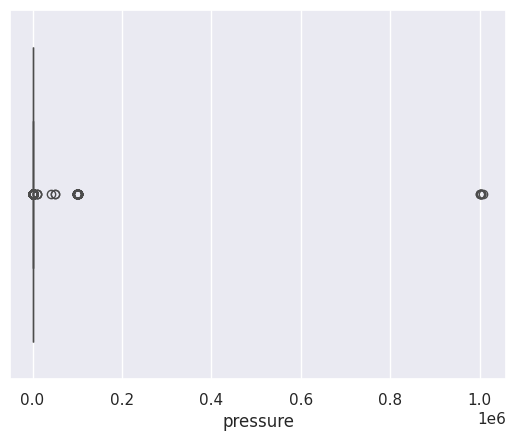

In [40]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()


Some `pressure` values exceed 100,000 hPa (10 MPa), which is higher than Venus’s atmospheric pressure—clearly unrealistic. To ensure data quality, we’ll replace all values above **1051 hPa** and below **931 hPa** with `NaN`, based on historical pressure extremes recorded in the Iberian Peninsula.



In [41]:
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan


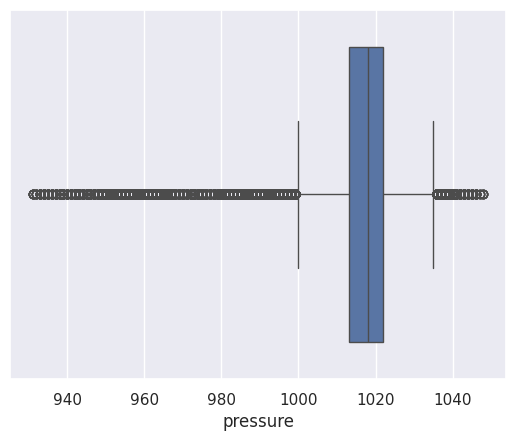

In [43]:
# Check for outliers in 'pressure' column
# Reset the index before plotting to avoid the error caused by duplicate index values
sns.boxplot(x=df_weather.reset_index()['pressure'])
plt.show()

Things look a lot better regarding atmospheric pressure ('pressure') as the column has been cleaned of extreme-case outliers. What about 'wind_speed' however?



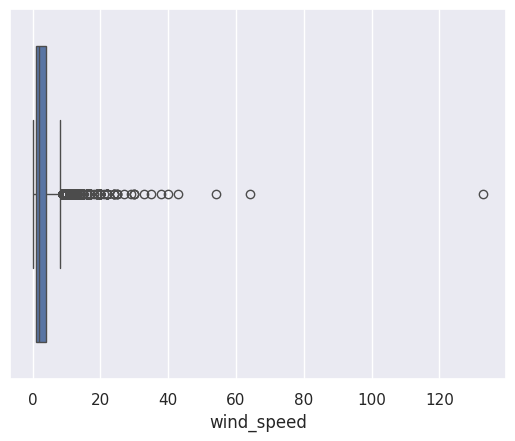

In [44]:
sns.boxplot(x=df_weather['wind_speed'])
plt.show()




Following a conservative approach, we’ll set `wind_speed` values above **50 m/s** as `NaN`, since this exceeds the upper limit for an F1 tornado (112 mph). Notably, the last F1 tornado in Spain (Gandia, 2012) occurred two years before our dataset begins.



In [45]:
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan


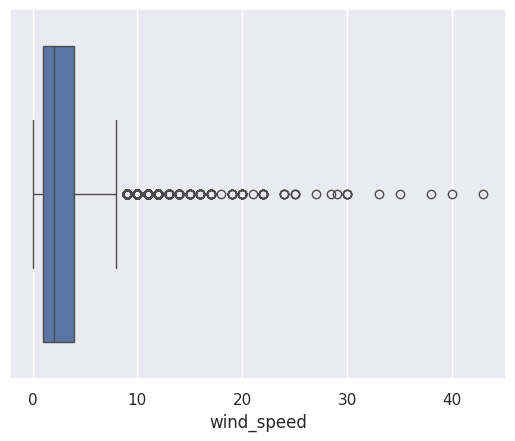

In [48]:
sns.boxplot(x=df_weather.reset_index()['wind_speed'])
plt.show()

In [47]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


<ipython-input-47-2b2de4e7e8c8>:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


Everything looks nice and clean and df_weather is also ready for use as input to our model. We also have to plot the 'rain_1h' and 'rain_3h' columns, as we have indicated that at least one of them (probably 'rain_3h') is quite problematic. Nevertheless, we will do so after we merge the two datasets.



**1.3. Merging the two datasets**

In [49]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]


In [50]:
df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final.columns


Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'weather_main_encoded_Barcelona', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'rain_

In [51]:
print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))


There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


**2. Visualizations and Time Series Analysis**

**2.1. Useful visualizations and insights**

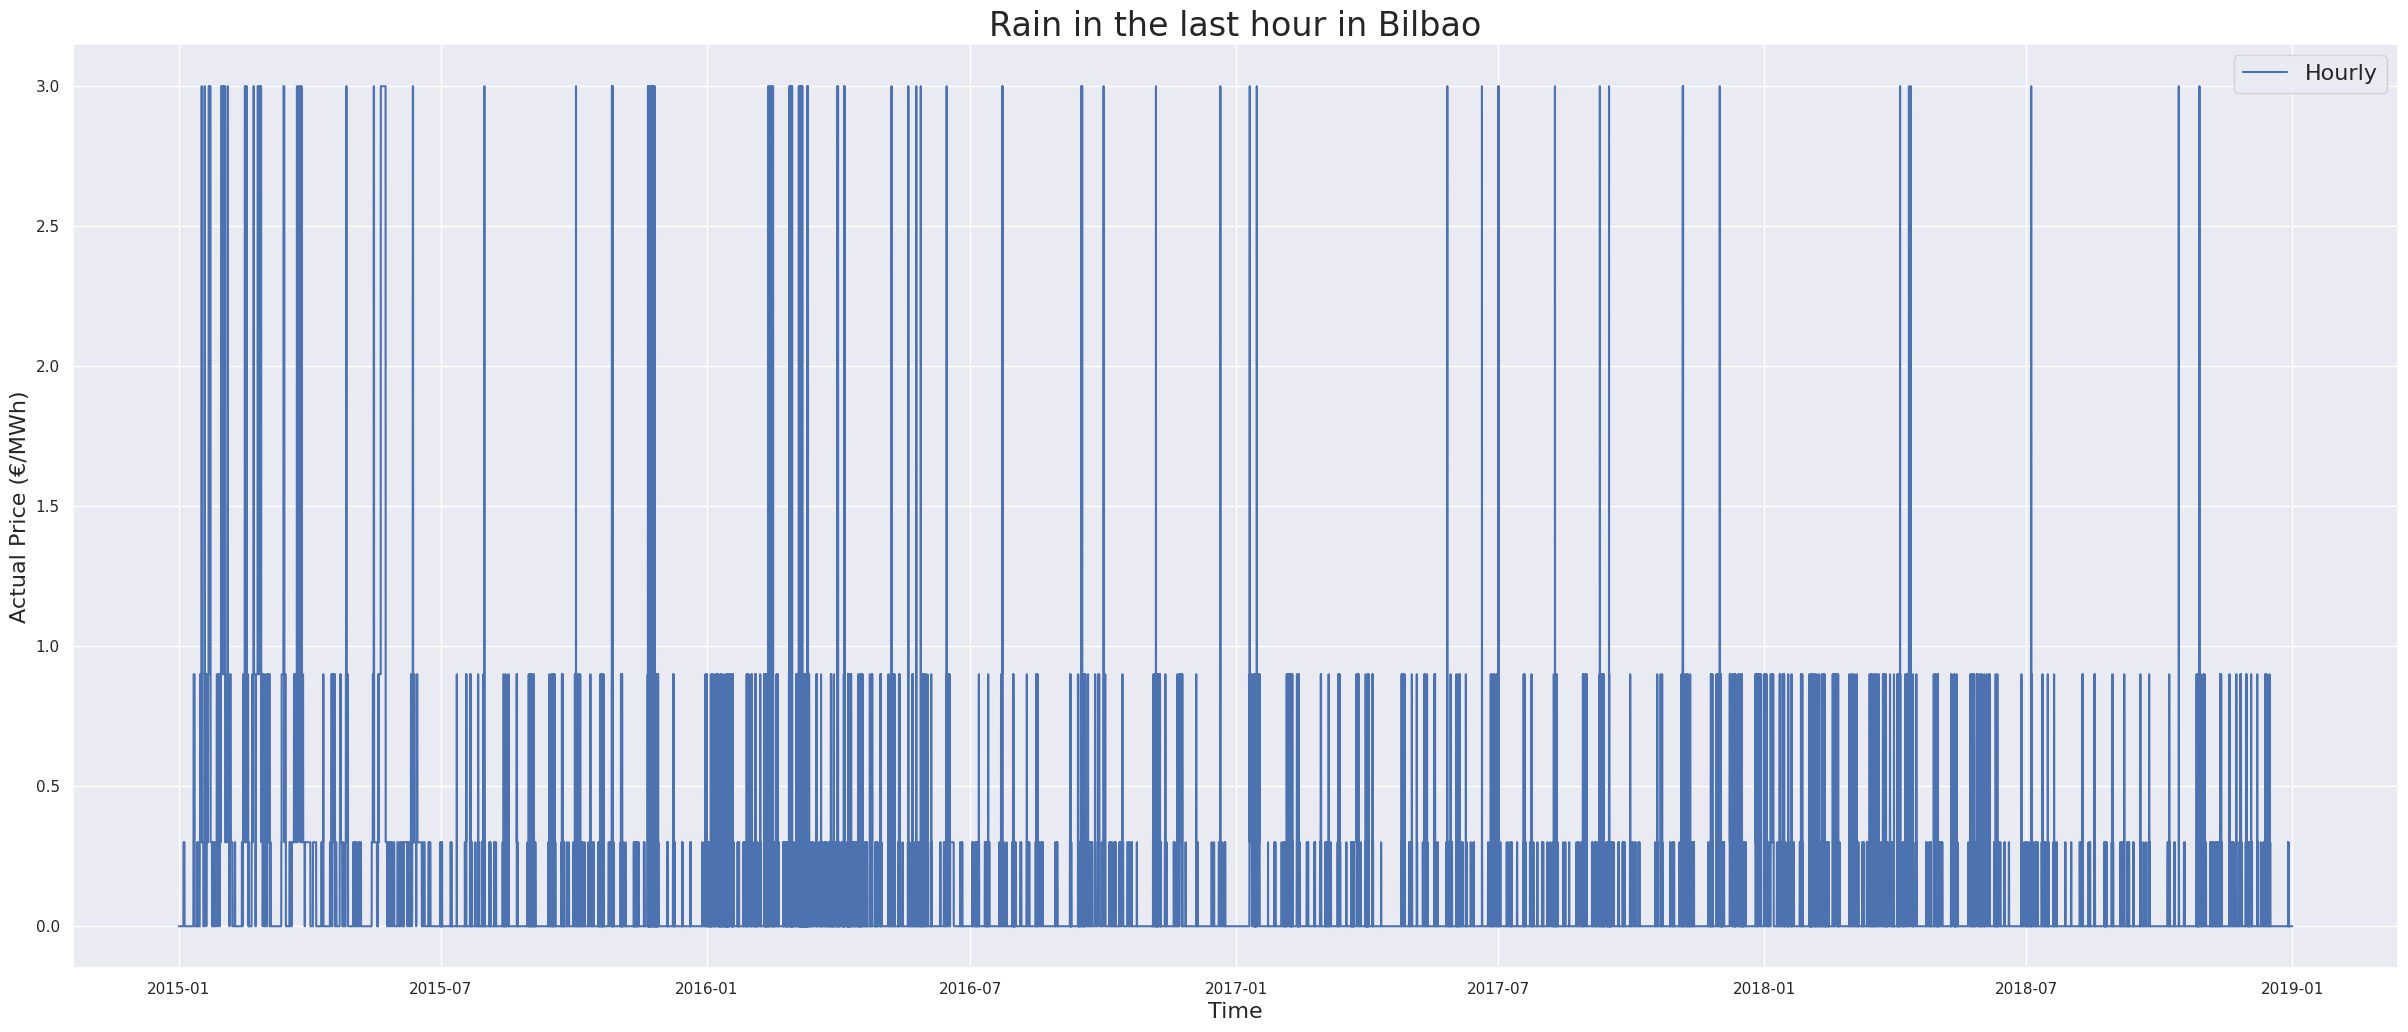

In [52]:
# Plot the 'rain_1h' for Bilbao

ax = plot_series(df_final, 'rain_1h_Bilbao',
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()


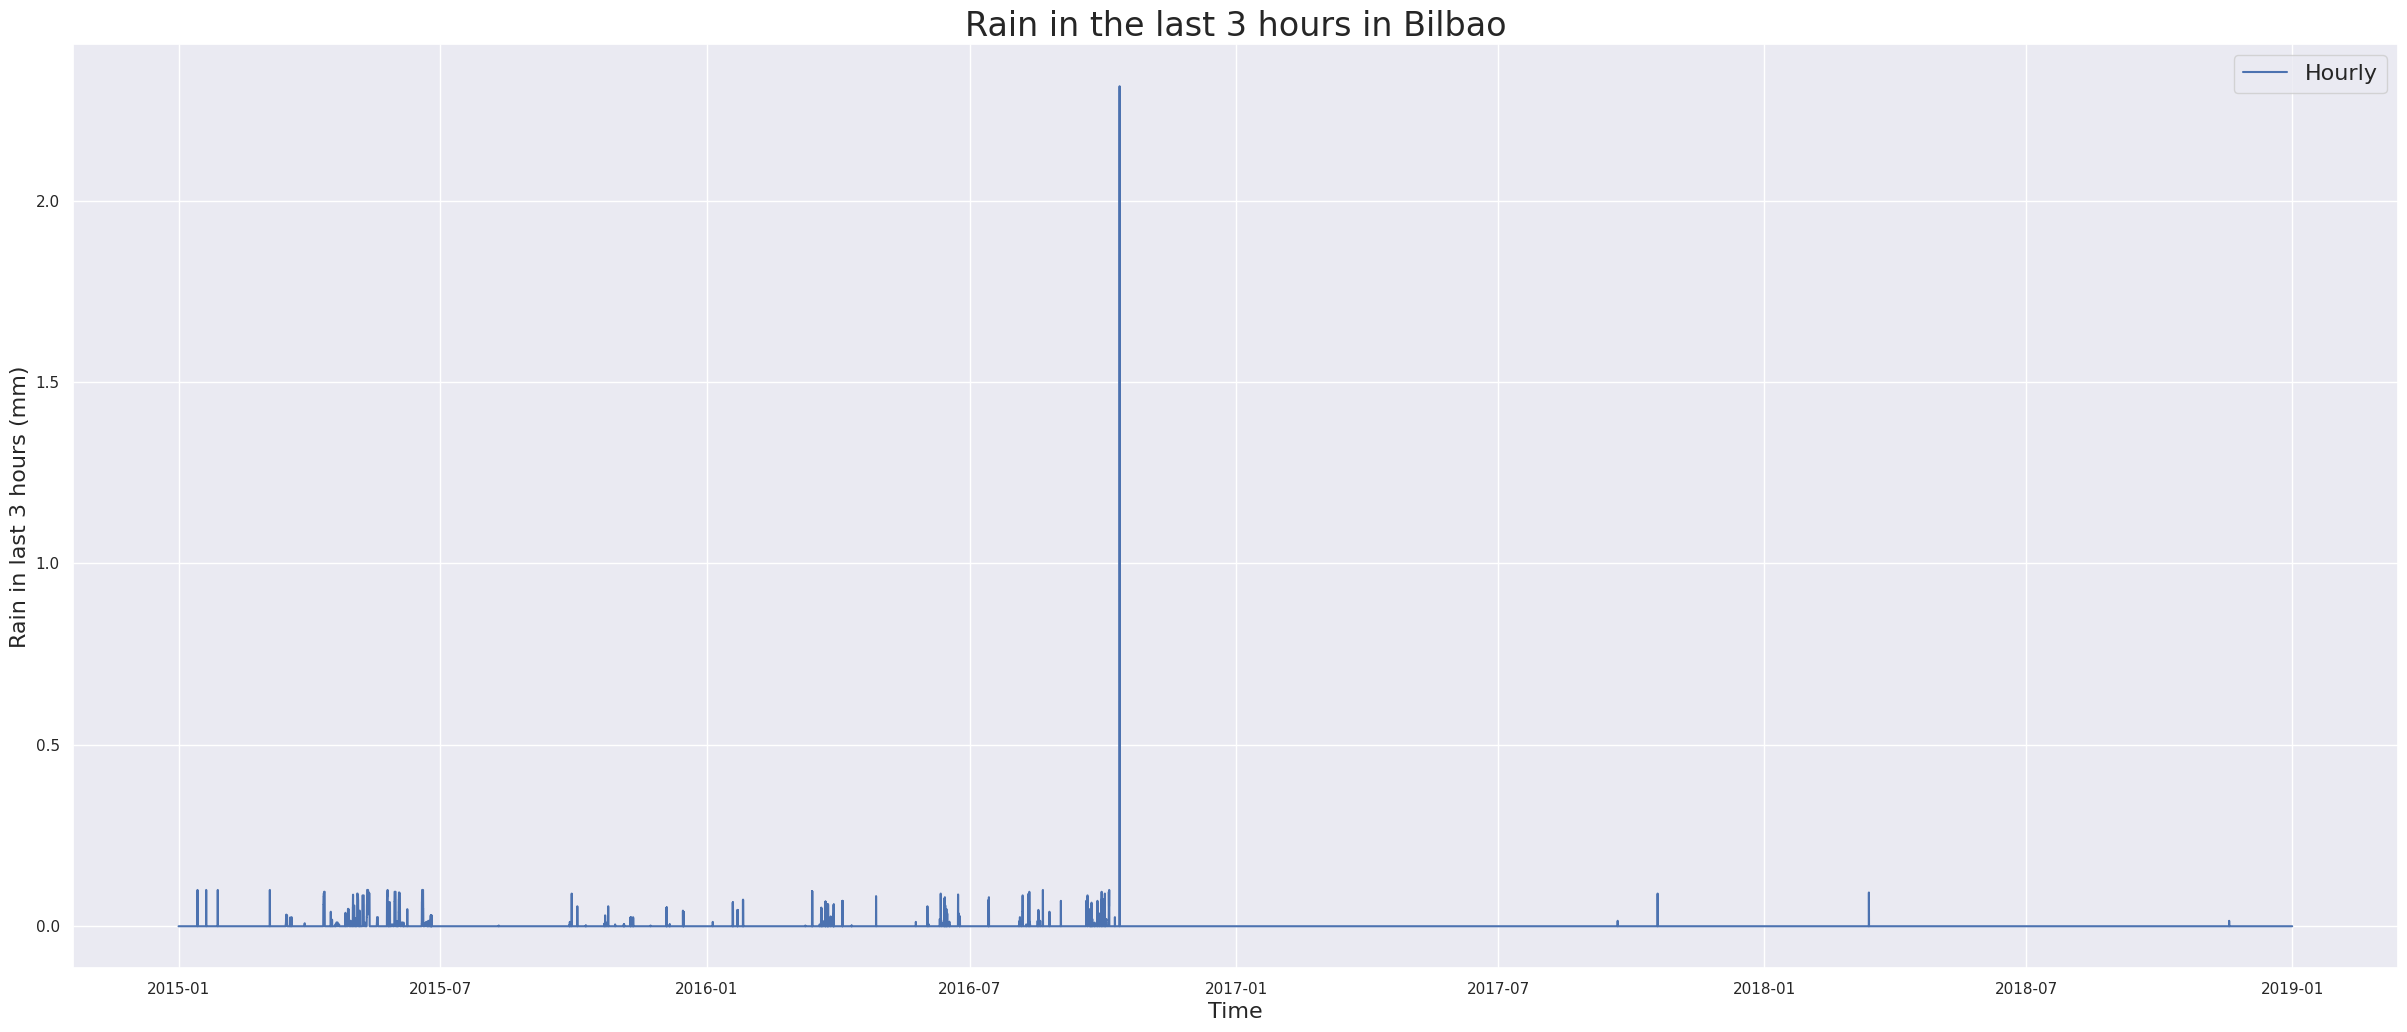

In [53]:
# Plot the 'rain_3h' for Bilbao

ax = plot_series(df_final, 'rain_3h_Bilbao',
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()


From the two figures aboce, we can conclude that 'rain_3h' is an unreliable feature which will drop from the dataset.



In [54]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)


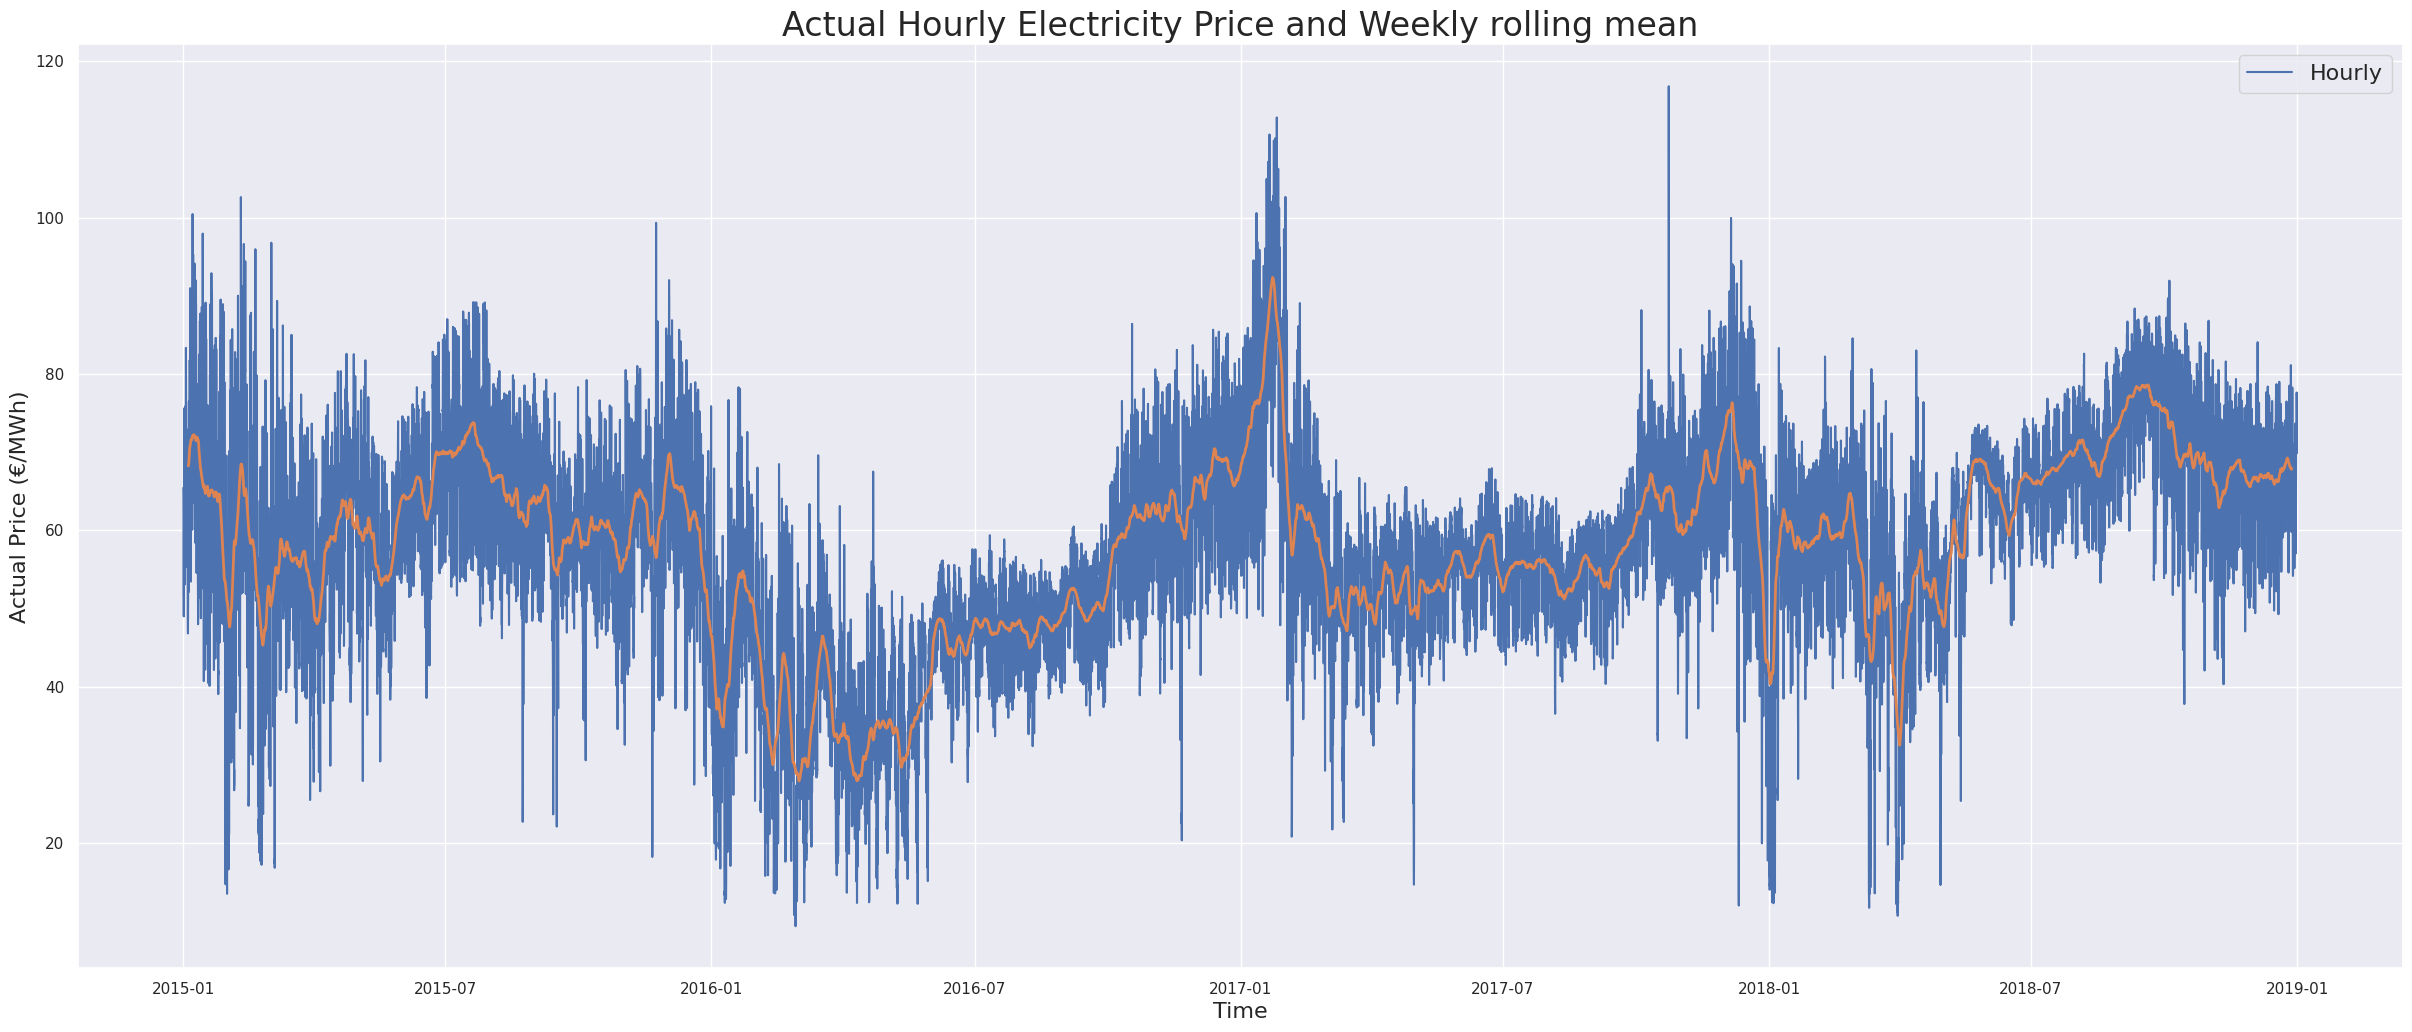

In [55]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()


<ipython-input-56-24746a5d67e8>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_price = df_final['price actual'].asfreq('M')
<ipython-input-56-24746a5d67e8>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  shifted = df_final['price actual'].asfreq('M').shift(12)


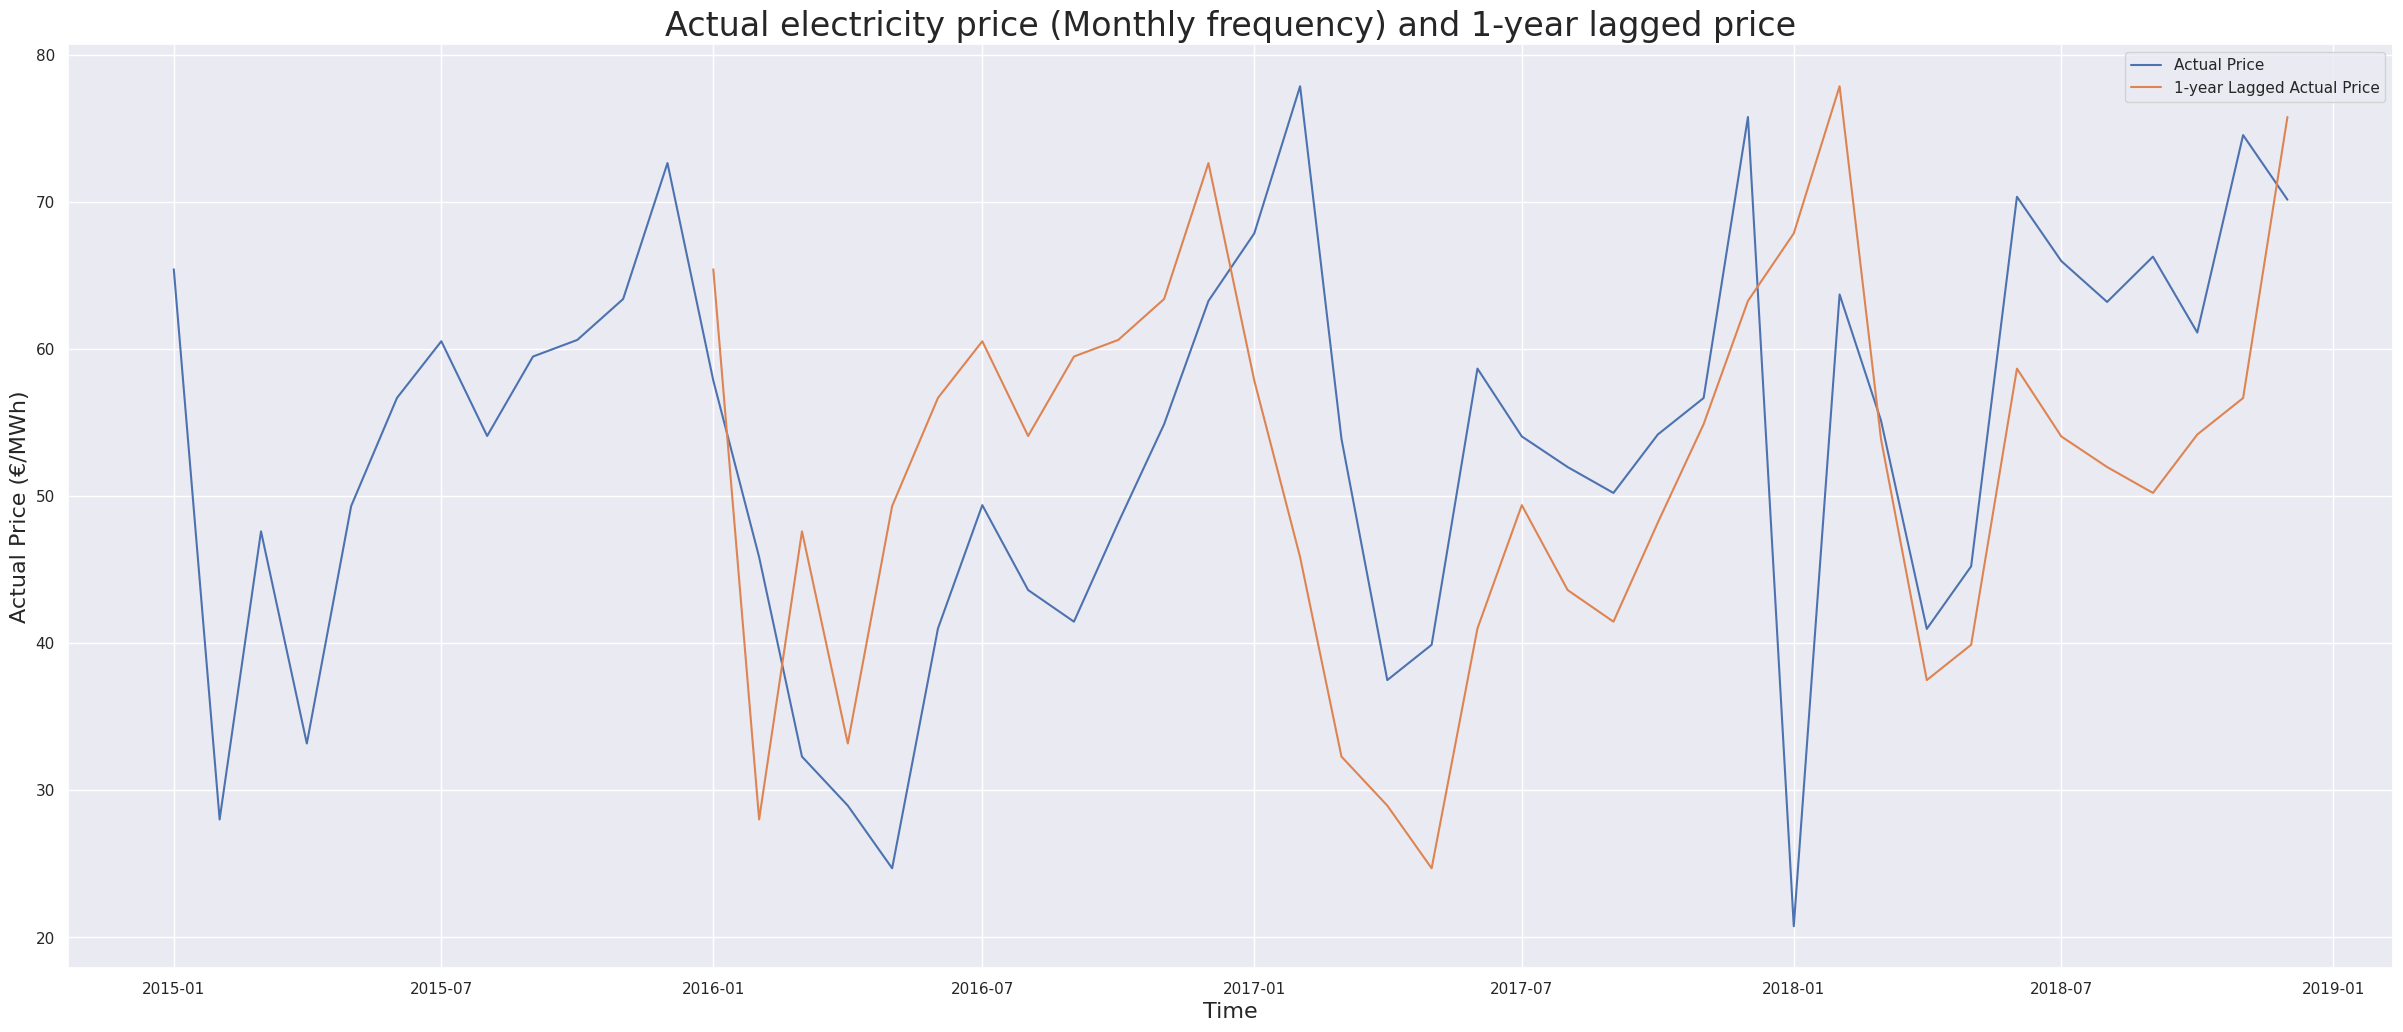

In [56]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()


The figure above shows the (resampled) monthly frequency of the actual electricity price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed seasonal patterns at the monthly scale, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.



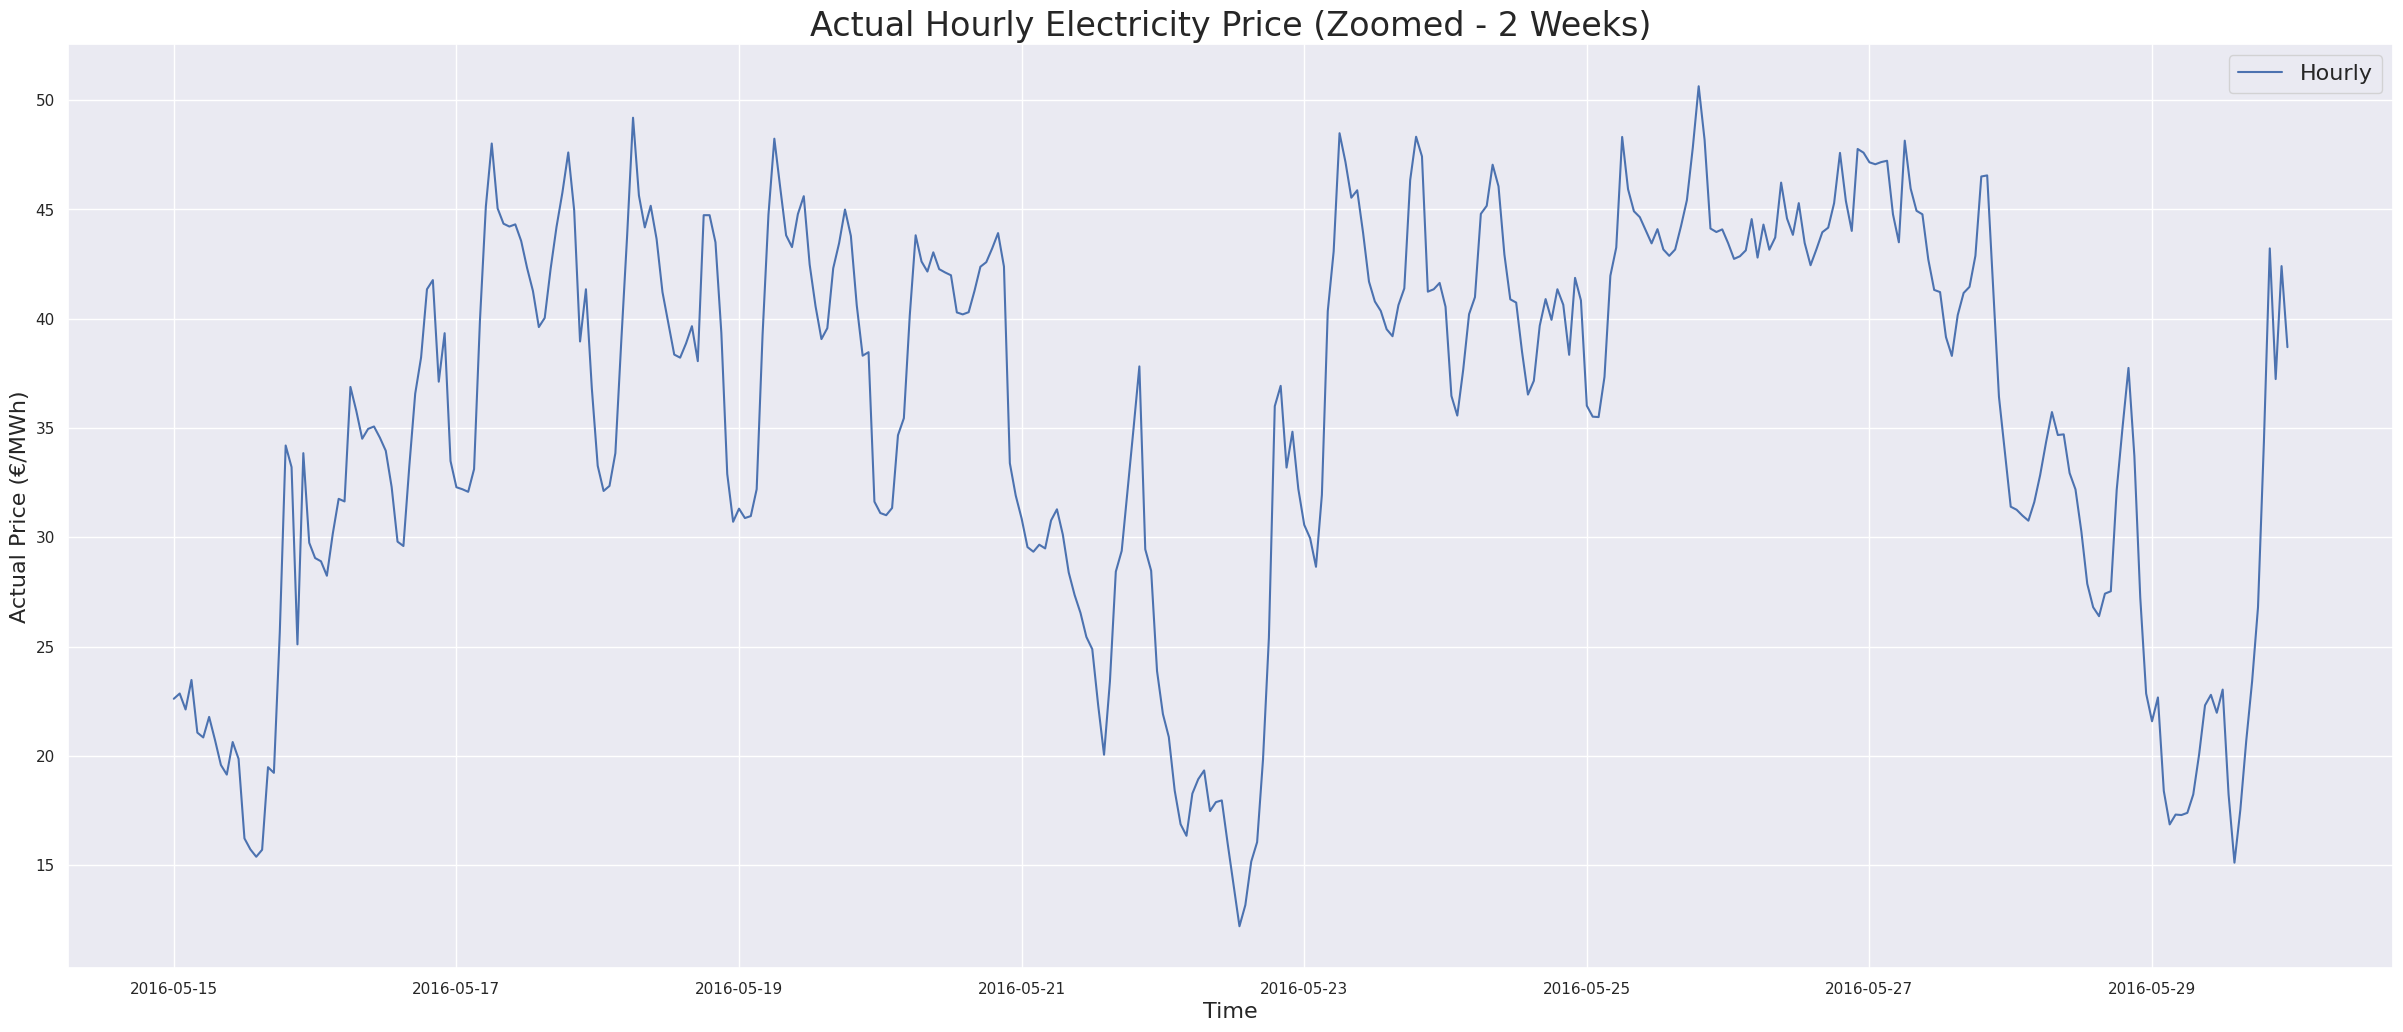

In [57]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()




The figure above shows the actual hourly electricity price from 15/06/2016 to 29/06/2016. We observe several patterns:

- **Weekly periodicity**: Prices are higher on business days and lower on weekends, especially Sundays.
- **Intraday periodicity**: Prices are higher during the day and lower at night.
- **Business hour periodicity**: Prices often drop during "siesta" (1:30 PM - 4:30 PM), reflecting Spain’s non-standard business hours.

We will later generate features to capture these periodicities.



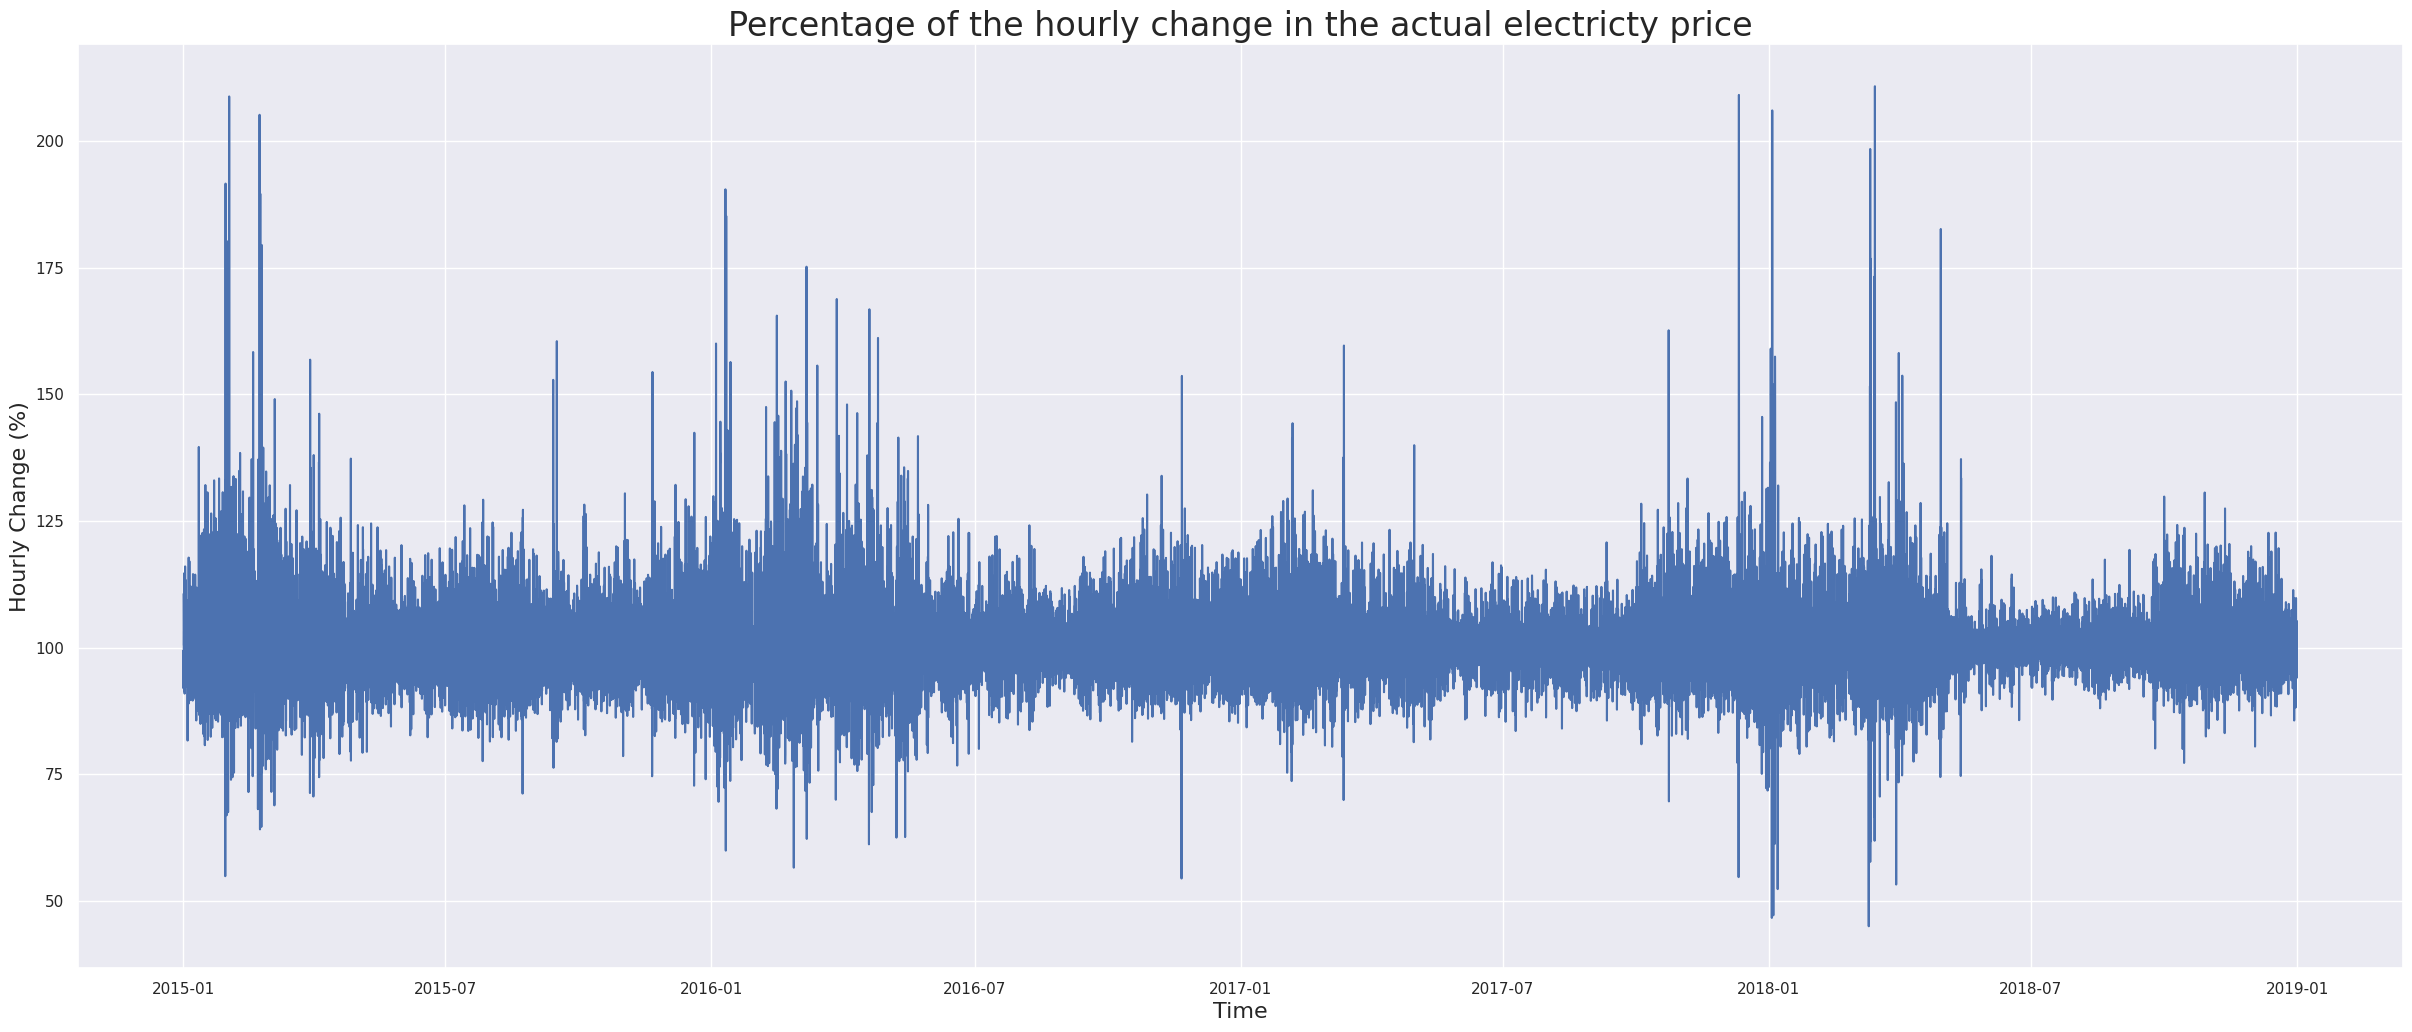

In [58]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)',
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()


From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price * 0.75) and +25% (actual price * 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).



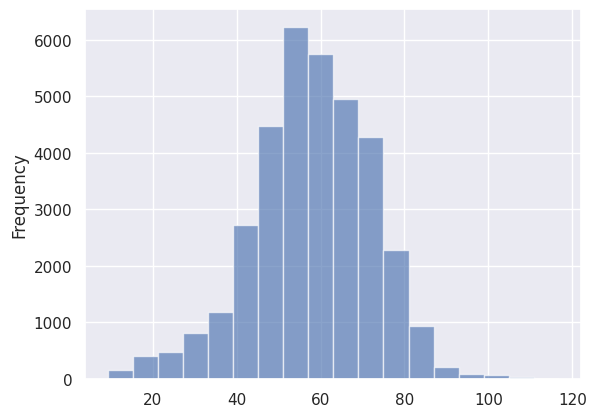

In [59]:
# Plot the histogram of the actual electricity price

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)


In the figure above, we can see that the actual energy price roughly follows a normal distribution and thus, could be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series.



**2.2. Decomposition and stationarity tests**

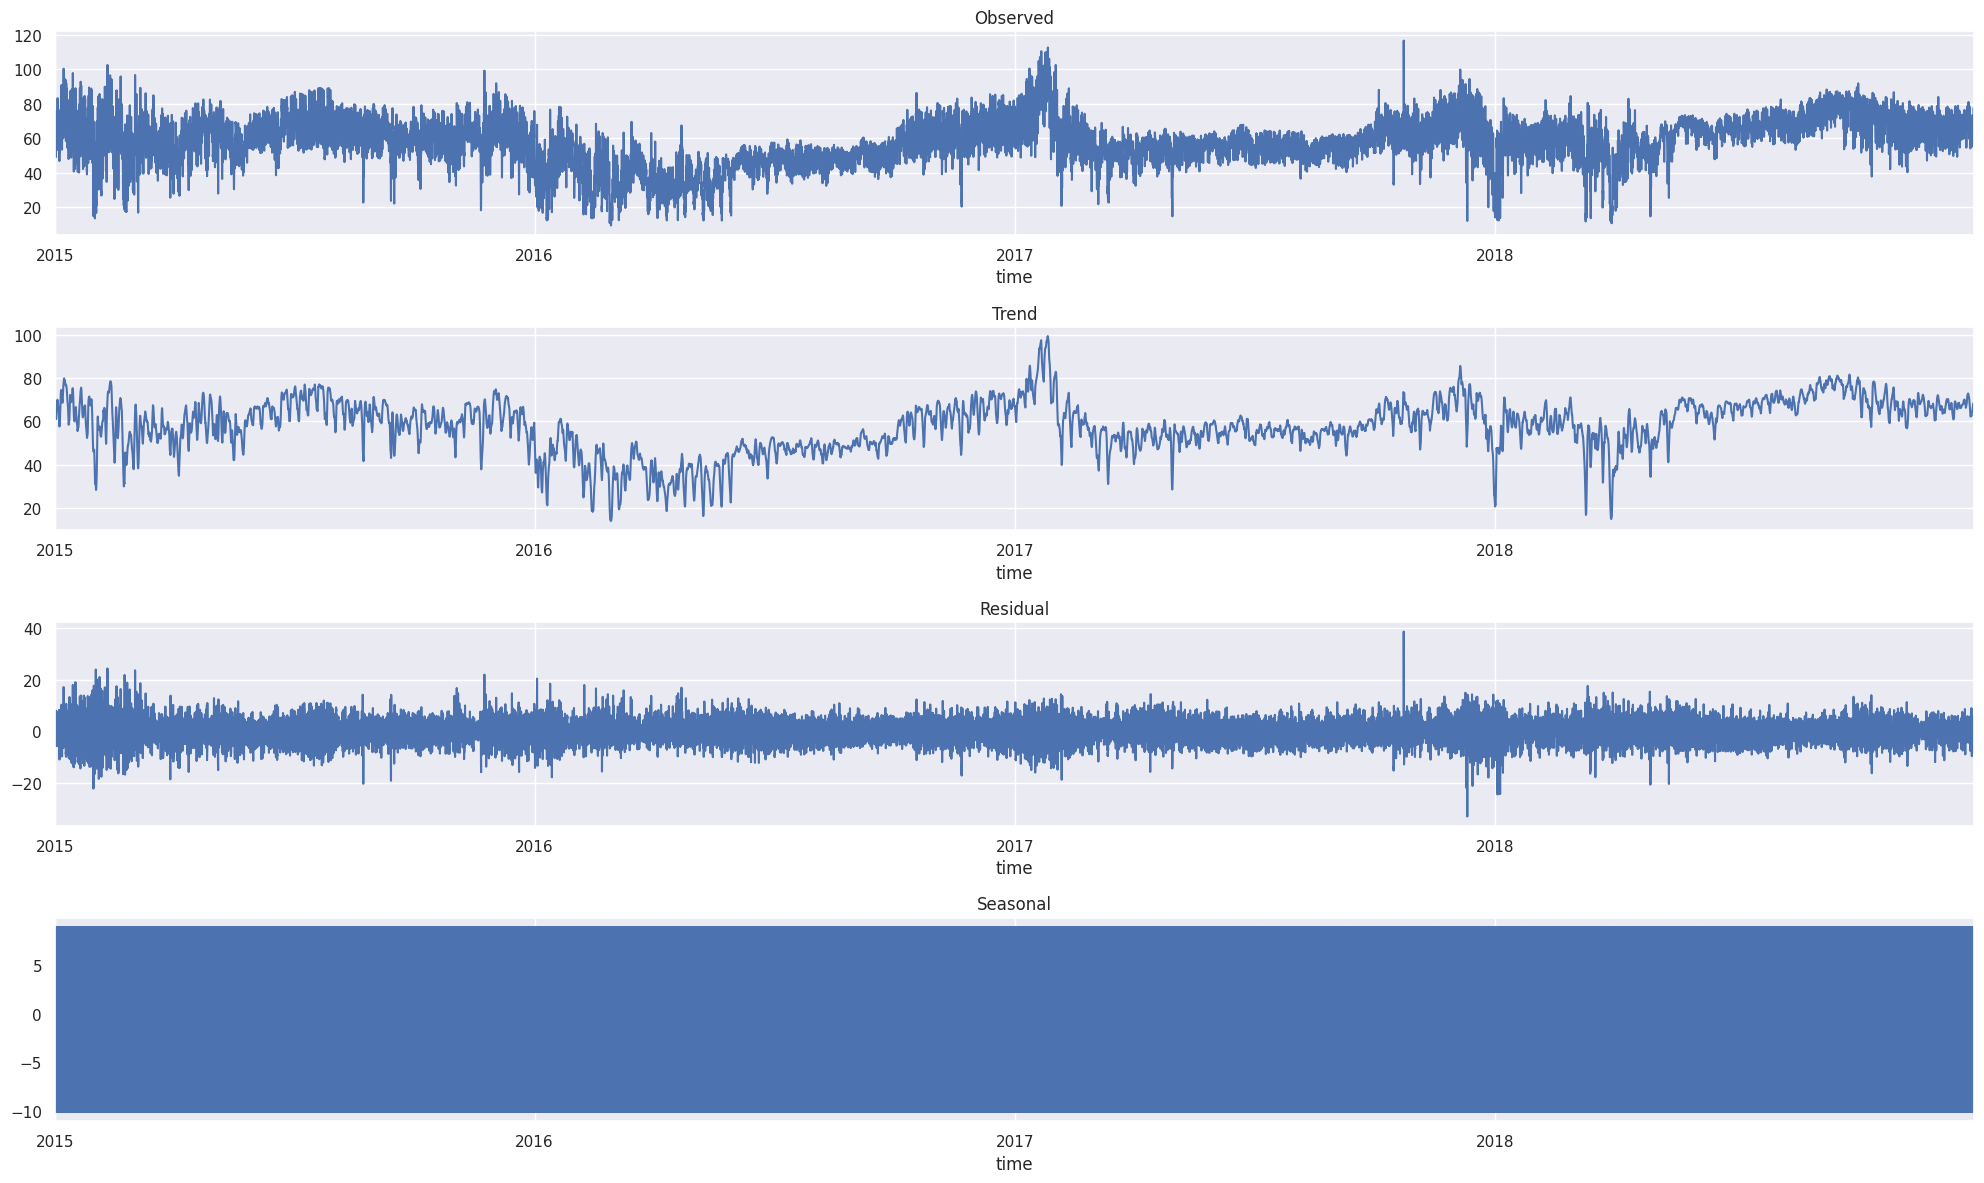

In [60]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()


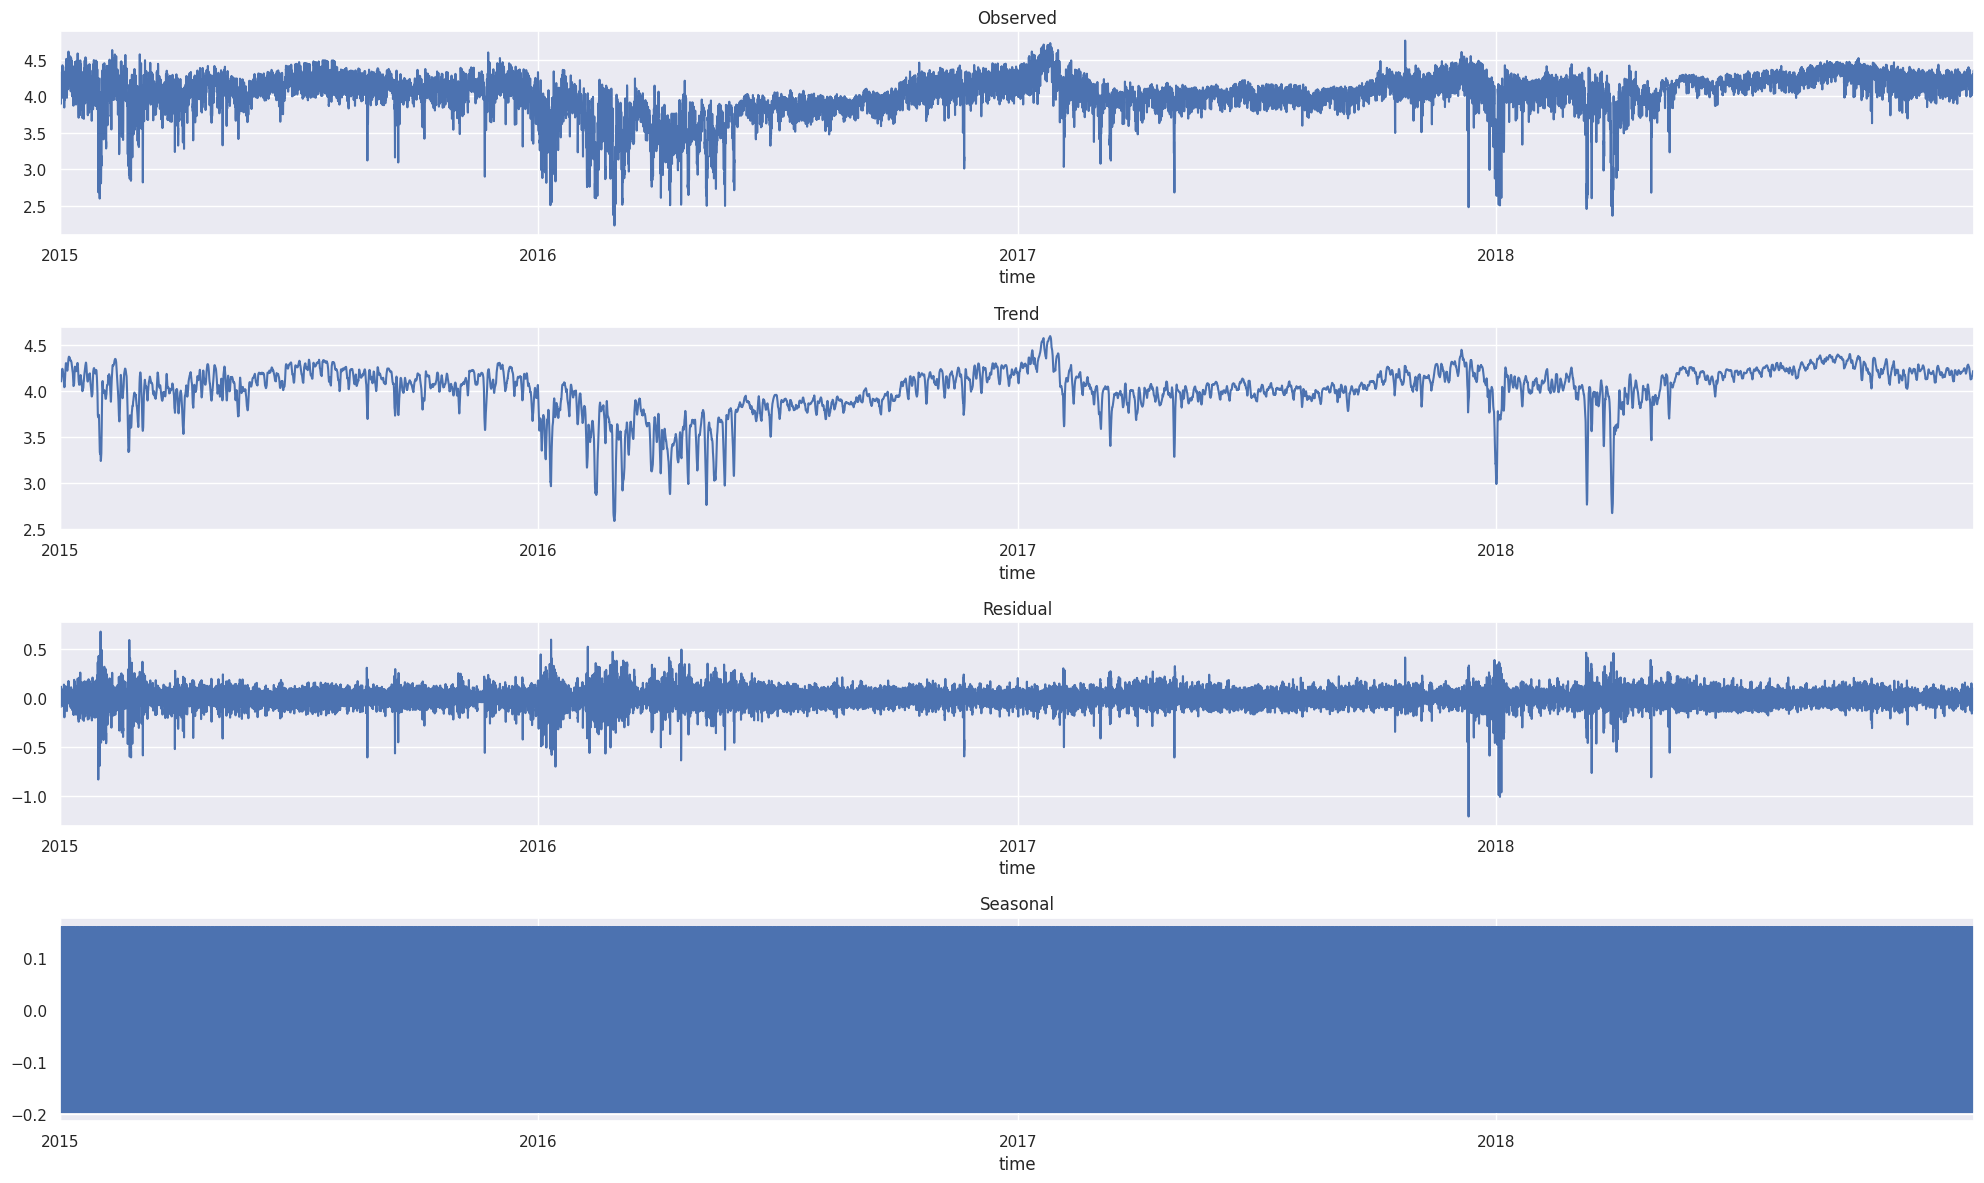

In [61]:
# Decompose the log electricity price time-series

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()


**2.3. Autocorrelation, partial autocorrelation and cross-correlation**

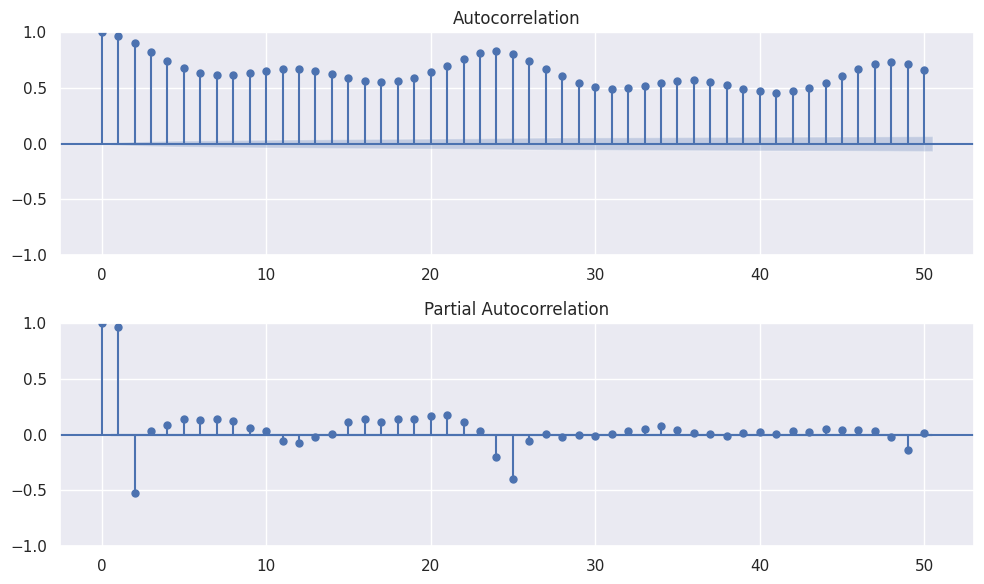

In [62]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models.

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the electricity price and each one of the features in the dataset. For example, below we can see the cross-correlation between the electricity price and the total load. We see that there are many time-lags with a correlation which is close to zero and could be ommited

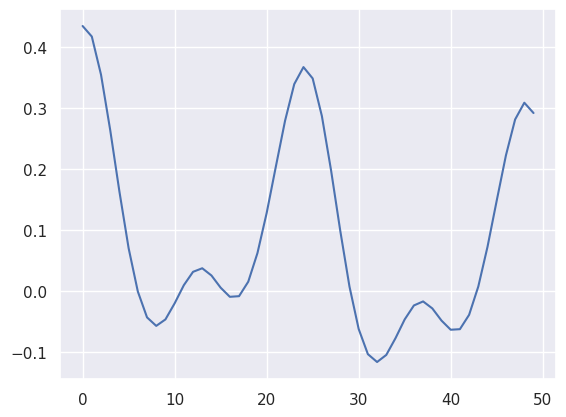

In [63]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()


For simplicity, we will just work with the correlations between the electricity price and the other features at each given hour.



In [64]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())


price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

From the above, we can already see some very interesting correlations among the energy price that we want to predict and the rest of the features. For example, the total energy load and the amount of energy generated from sources related to fossil fuels, is positively correlated with the electricity price. In contrast, the wind speed in almost every city and the amount of storage energy cosumed through hydroelectric pumping is negatively correlated with the energy price. We will go ahead and drop the 'snow_3h_Barcelona' and 'snow_3h_Seville' which give NaNs in their correlations with the electricity actual price.



In [65]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

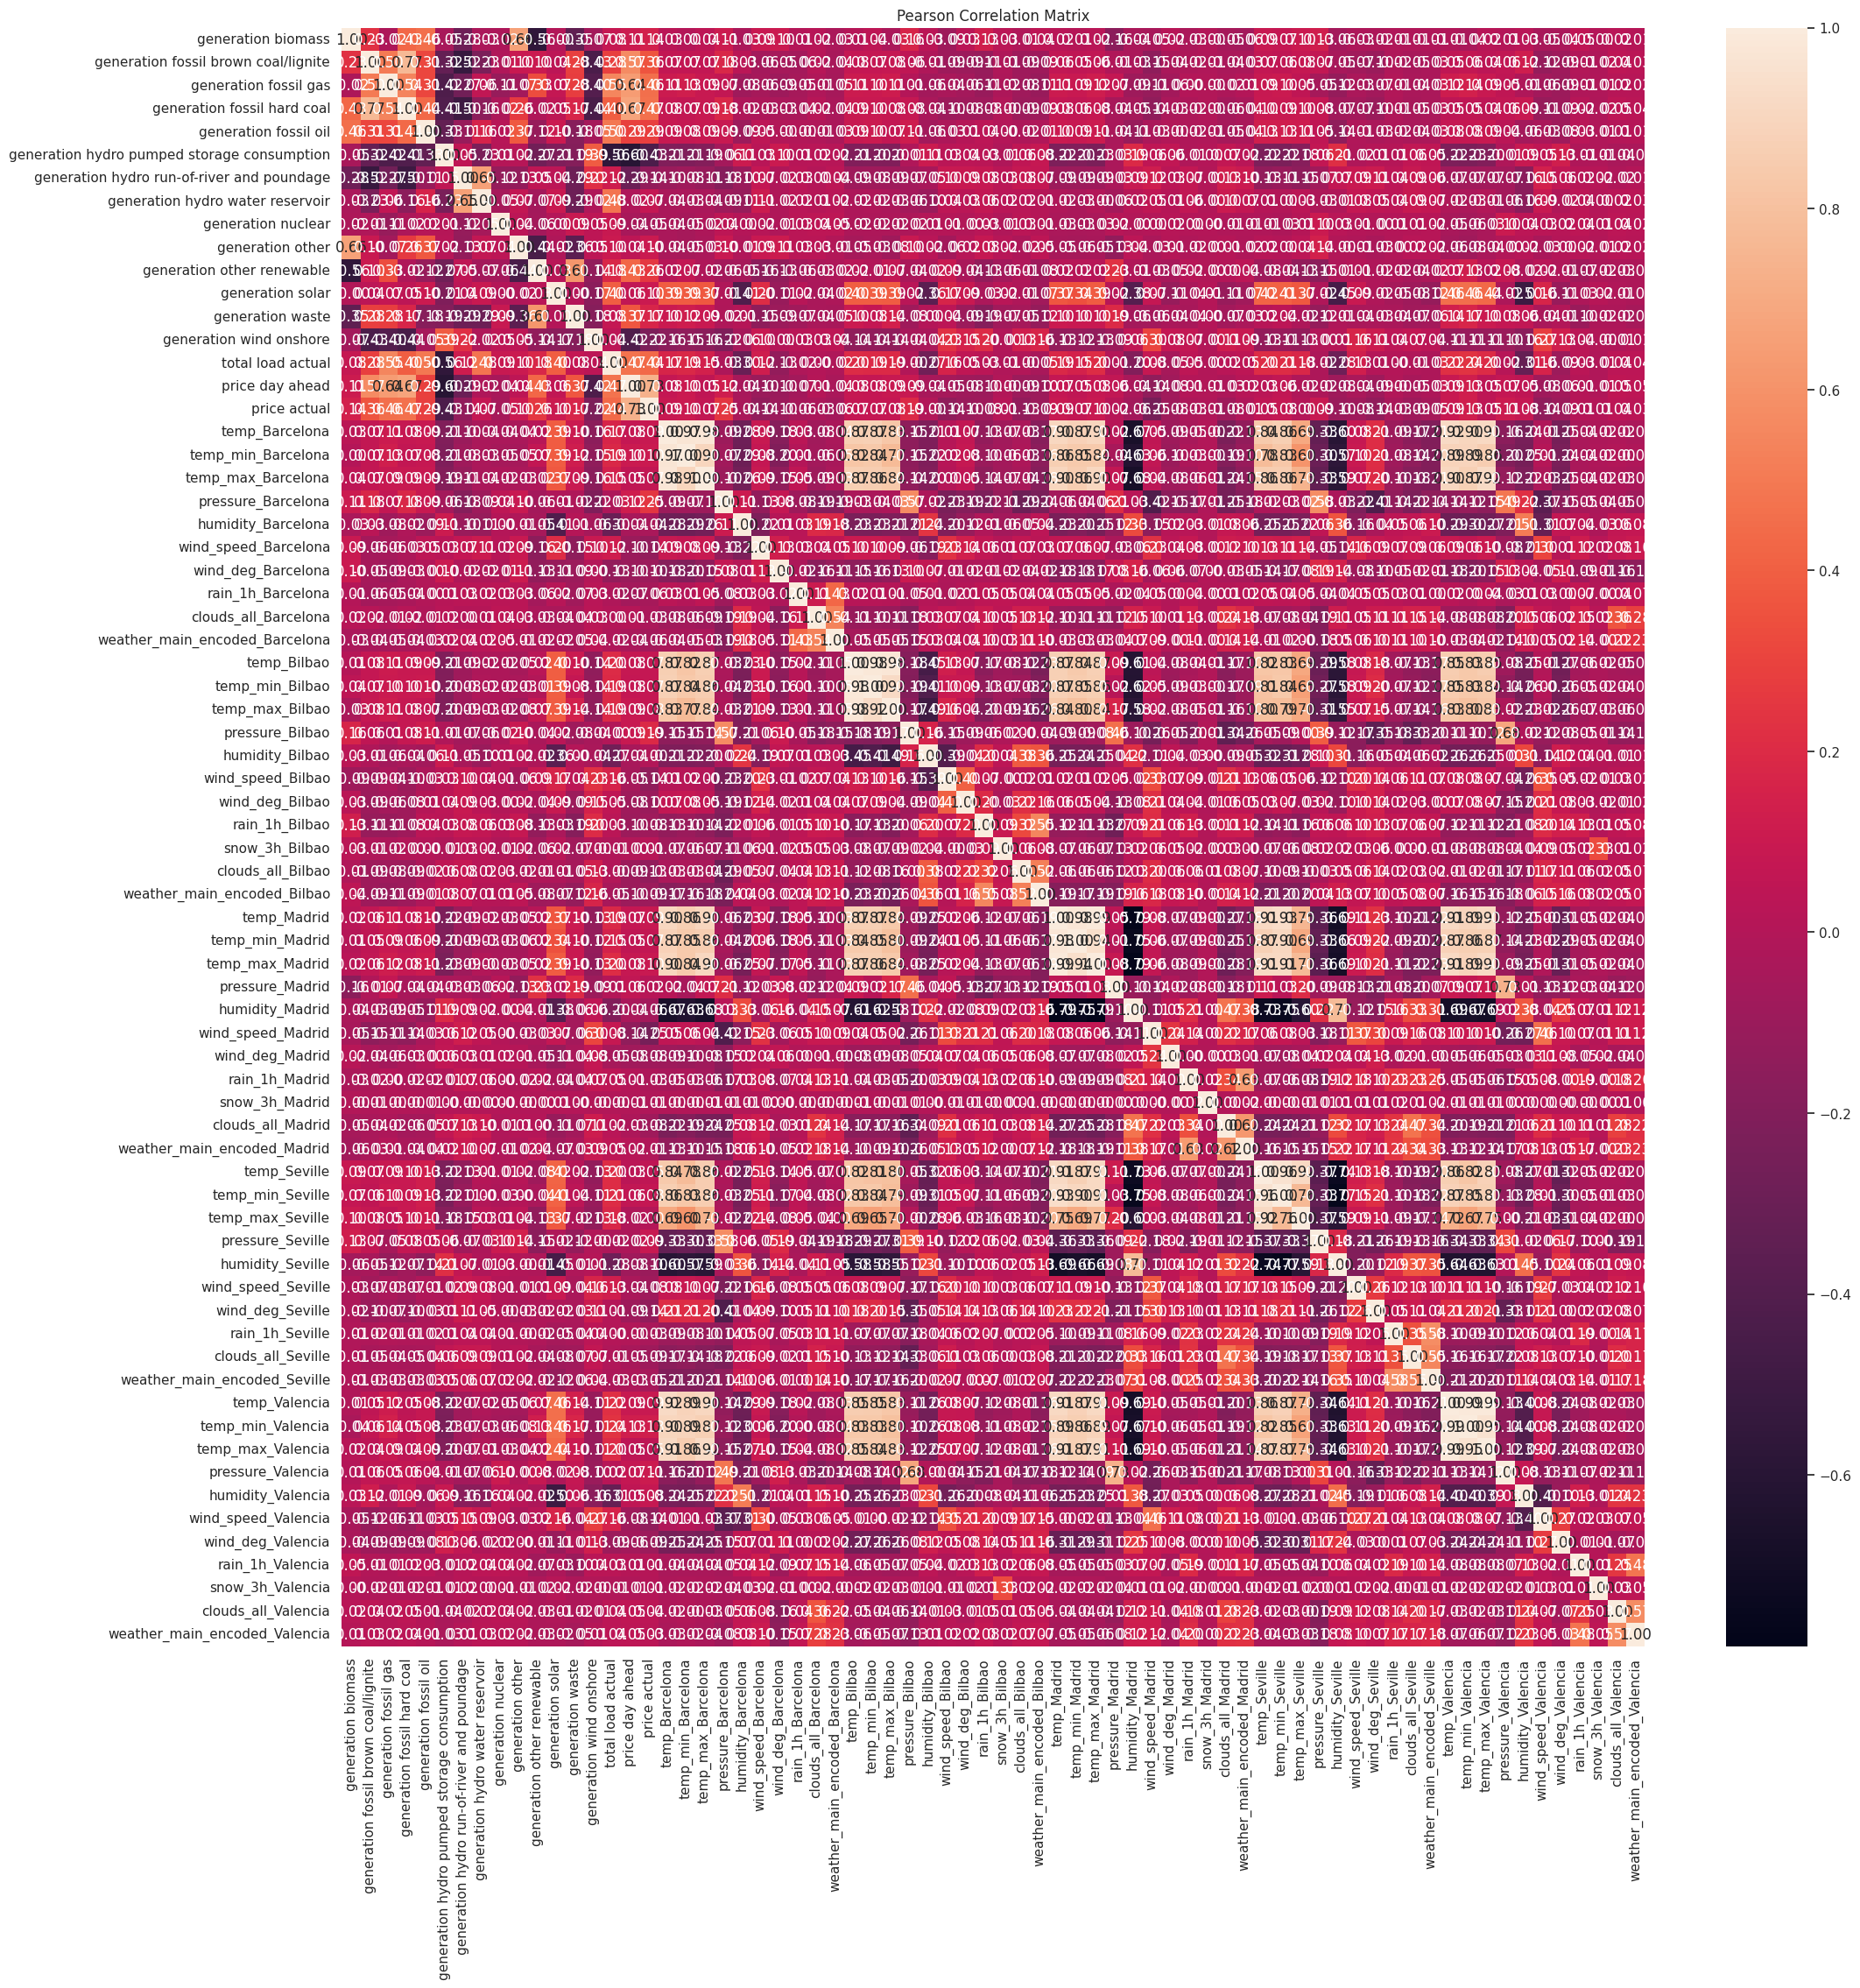

In [66]:
correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other

In [67]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())


generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).



**3. Feature Engineering**

**3.1. Feature generation**

In [68]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month


We’ll generate a feature for **business hours** based on Spain’s unique schedule. The value will be:

- **2** for hours within the business hours (9:30 AM - 1:30 PM, 4:30 PM - 8 PM, Monday-Saturday).
- **1** for hours during the "siesta" (1:30 PM - 4:30 PM).
- **0** for all other hours.



In [69]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0




We’ll also create a **weekend** feature to account for the differences between weekdays and weekends. The values will be:

- **0** for weekdays (Monday-Friday)
- **1** for Saturdays
- **2** for Sundays

This will help capture variations in business activities and electricity price patterns.



In [70]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In order to reduce the dimensionality and potentially acquire a new kind of information, for every given hour, we will subtract the minimum temperature ('temp_min') from the maximum temperature ('temp_max') for each city and we will name that feature 'temprange{name of city}'

In [71]:
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)



Given the high correlation between temperatures across cities, we’ll create a **weighted temperature** feature based on each city's population:

- **Madrid**: 6,155,116
- **Barcelona**: 5,179,243
- **Valencia**: 1,645,342
- **Seville**: 1,305,342
- **Bilbao**: 987,000

This will provide a more representative temperature feature for the entire region.



In [72]:
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop


In [73]:
cities_weights = {'Madrid': weight_Madrid,
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [74]:
for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted


We will also generate a new feature which aggregates both energy sources which are related to coal and are highly correlated (0.7688).

In [75]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

**3.2. Feature selection**

In [76]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [77]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [78]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)


In [79]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))


In [80]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [81]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [82]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])


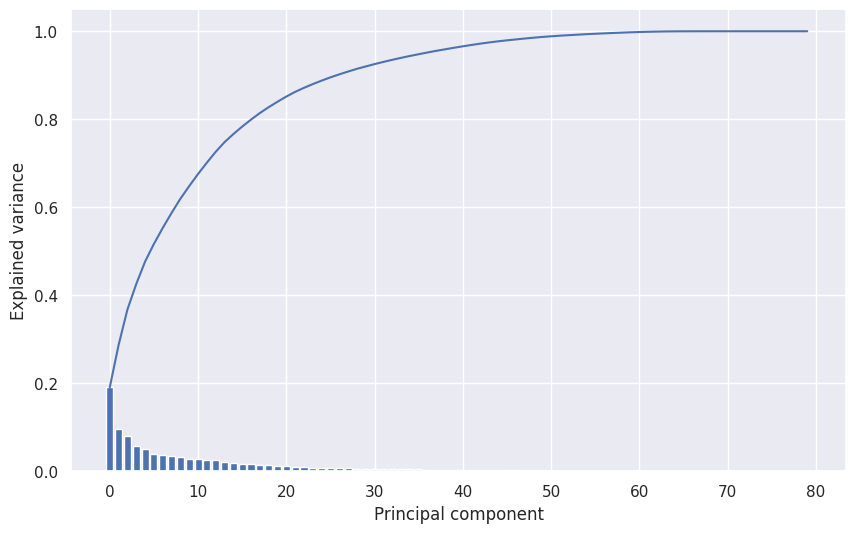

In [83]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()


In [84]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)


In [85]:
X_pca.shape

(35064, 18)

In [86]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0


In [87]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)


In [88]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)


In [89]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)


In [90]:
batch_size = 32
buffer_size = 1000


In [91]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)


In [92]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [93]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)


**4. Electricity Price Forecasting**

In [94]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()



**4.2. XGBoost**

In [95]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])


In [96]:
param = {'eta': 0.03, 'max_depth': 180,
         'subsample': 1.0, 'colsample_bytree': 0.95,
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse',
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:31:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:31:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.12945	eval-rmse:0.10910
[1]	train-rmse:0.12581	eval-rmse:0.10602
[2]	train-rmse:0.12249	eval-rmse:0.10336
[3]	train-rmse:0.11907	eval-rmse:0.10055
[4]	train-rmse:0.11576	eval-rmse:0.09774
[5]	train-rmse:0.11275	eval-rmse:0.09531
[6]	train-rmse:0.10964	eval-rmse:0.09270
[7]	train-rmse:0.10663	eval-rmse:0.09018
[8]	train-rmse:0.10391	eval-rmse:0.08797
[9]	train-rmse:0.10107	eval-rmse:0.08561
[10]	train-rmse:0.09833	eval-rmse:0.08329
[11]	train-rmse:0.09567	eval-rmse:0.08106
[12]	train-rmse:0.09329	eval-rmse:0.07913
[13]	train-rmse:0.09079	eval-rmse:0.07707
[14]	train-rmse:0.08838	eval-rmse:0.07503
[15]	train-rmse:0.08604	eval-rmse:0.07308
[16]	train-rmse:0.08379	eval-rmse:0.07121
[17]	train-rmse:0.08161	eval-rmse:0.06941
[18]	train-rmse:0.07950	eval-rmse:0.06769
[19]	train-rmse:0.07745	eval-rmse:0.06597
[20]	train-rmse:0.07548	eval-rmse:0.06433
[21]	train-rmse:0.07357	eval-rmse:0.06275
[22]	train-rmse:0.07172	eval-rmse:0.06121
[23]	train-rmse:0.06994	eval-rmse:0.05972
[2

In [97]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))


RMSE of hour-ahead electricity price XGBoost forecast: 2.24


**4.3. LSTM**

In [99]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape,
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)
multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,                          metrics=metric)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])


Epoch 1/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4975 - root_mean_squared_error: 0.5458

845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - loss: 0.4965 - root_mean_squared_error: 0.5452 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0054 - root_mean_squared_error: 0.0725

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0054 - root_mean_squared_error: 0.0725 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 3/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0041 - root_mean_squared_error: 0.0632

845/845 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0041 - root_mean_squared_error: 0.0632 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0543
Epoch 4/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541
Epoch 6/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 7/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475

845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 8/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453

845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 9/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446

845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 10/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422

845/845 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 11/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410

845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 12/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 13/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 14/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387

845/845 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 15/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371

845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 16/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 17/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 18/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 19/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343

845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 9.4711e-04 - val_root_mean_squared_error: 0.0308
Epoch 20/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 21/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 9.2255e-04 - val_root_mean_squared_error: 0.0304
Epoch 22/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319

845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 8.2066e-04 - val_root_mean_squared_error: 0.0286
Epoch 23/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 8.9229e-04 - val_root_mean_squared_error: 0.0299
Epoch 24/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 7.7685e-04 - val_root_mean_squared_error: 0.0279
Epoch 25/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 9.4019e-04 - val_root_mean_squared_error: 0.0307
Epoch 26/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 9.6385e-04 - root_mean_squared_error: 0.0309 - val_loss: 8.1370e-04 - val_root_mean_squared_error: 0.0285
Epoch 27/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - loss: 9.5430e-04 - root_mean_squared_error: 0.0308 - val_loss: 8.1994e-04 - val_root_mean_squared_error: 0.0286
Epoch 28/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 9.1870e-04 - root_mean_squared_error: 0.0302 - val_loss: 8.3883e-04 - val_root_mean_squared_error: 0.0290
Epoch 29/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.9660e-04 - root_mean_squared_error: 0.0298

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 8.9605e-04 - root_mean_squared_error: 0.0298 - val_loss: 7.5916e-04 - val_root_mean_squared_error: 0.0276
Epoch 30/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - loss: 8.8595e-04 - root_mean_squared_error: 0.0297 - val_loss: 8.0821e-04 - val_root_mean_squared_error: 0.0284
Epoch 31/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 8.8776e-04 - root_mean_squared_error: 0.0297 - val_loss: 7.6168e-04 - val_root_mean_squared_error: 0.0276
Epoch 32/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.5227e-04 - root_mean_squared_error: 0.0291

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.5211e-04 - root_mean_squared_error: 0.0291 - val_loss: 7.4174e-04 - val_root_mean_squared_error: 0.0272
Epoch 33/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.7370e-04 - root_mean_squared_error: 0.0295 - val_loss: 7.7025e-04 - val_root_mean_squared_error: 0.0278
Epoch 34/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.2992e-04 - root_mean_squared_error: 0.0287

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.2948e-04 - root_mean_squared_error: 0.0287 - val_loss: 7.0302e-04 - val_root_mean_squared_error: 0.0265
Epoch 35/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.4131e-04 - root_mean_squared_error: 0.0289

845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 8.4101e-04 - root_mean_squared_error: 0.0289 - val_loss: 6.6057e-04 - val_root_mean_squared_error: 0.0257
Epoch 36/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.0070e-04 - root_mean_squared_error: 0.0282 - val_loss: 7.4093e-04 - val_root_mean_squared_error: 0.0272
Epoch 37/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.1441e-04 - root_mean_squared_error: 0.0285 - val_loss: 6.7424e-04 - val_root_mean_squared_error: 0.0260
Epoch 38/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.2448e-04 - root_mean_squared_error: 0.0286 - val_loss: 8.3299e-04 - val_root_mean_squared_error: 0.0289
Epoch 39/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0359e-04 - root_mean_squared_error: 0.0283

845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 8.0345e-04 - root_mean_squared_error: 0.0283 - val_loss: 6.3357e-04 - val_root_mean_squared_error: 0.0252
Epoch 40/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.1733e-04 - root_mean_squared_error: 0.0285 - val_loss: 6.6022e-04 - val_root_mean_squared_error: 0.0257
Epoch 41/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 7.8874e-04 - root_mean_squared_error: 0.0280 - val_loss: 6.6042e-04 - val_root_mean_squared_error: 0.0257
Epoch 42/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.0913e-04 - root_mean_squared_error: 0.0283 - val_loss: 6.3500e-04 - val_root_mean_squared_error: 0.0252
Epoch 43/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 7.7656e-04 - root_mean_squared_error: 0.0278 - val_loss: 6.7531e-04 - val_root_mean_squared_error: 0.0260
Epoch 44/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9785e-04 - root_mean_squared_error: 0.0282

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.9769e-04 - root_mean_squared_error: 0.0281 - val_loss: 6.2110e-04 - val_root_mean_squared_error: 0.0249
Epoch 45/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.6536e-04 - root_mean_squared_error: 0.0276 - val_loss: 6.8781e-04 - val_root_mean_squared_error: 0.0262
Epoch 46/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 7.7015e-04 - root_mean_squared_error: 0.0277 - val_loss: 7.0931e-04 - val_root_mean_squared_error: 0.0266
Epoch 47/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - loss: 7.7605e-04 - root_mean_squared_error: 0.0278 - val_loss: 6.3745e-04 - val_root_mean_squared_error: 0.0252
Epoch 48/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.5553e-04 - root_mean_squared_error: 0.0274

845/845 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 7.5525e-04 - root_mean_squared_error: 0.0274 - val_loss: 6.1340e-04 - val_root_mean_squared_error: 0.0248
Epoch 49/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.5582e-04 - root_mean_squared_error: 0.0274 - val_loss: 6.8160e-04 - val_root_mean_squared_error: 0.0261
Epoch 50/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.3629e-04 - root_mean_squared_error: 0.0271 - val_loss: 6.6086e-04 - val_root_mean_squared_error: 0.0257
Epoch 51/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 7.3398e-04 - root_mean_squared_error: 0.0270 - val_loss: 6.1628e-04 - val_root_mean_squared_error: 0.0248
Epoch 52/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.3178e-04 - root_mean_squared_error: 0.0270 - val_loss: 6.2518e-04 - val_root_mean_squared_error: 0.0250
Epoch 53/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - loss: 7.3277e-04 - root_mean_squared_error: 0.0270 - val_loss: 7.1354e-04 - val_root_mean_squared_error: 

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.2232e-04 - root_mean_squared_error: 0.0268 - val_loss: 5.8588e-04 - val_root_mean_squared_error: 0.0242
Epoch 59/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 7.1450e-04 - root_mean_squared_error: 0.0267 - val_loss: 7.0772e-04 - val_root_mean_squared_error: 0.0266
Epoch 60/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.9787e-04 - root_mean_squared_error: 0.0263 - val_loss: 6.7342e-04 - val_root_mean_squared_error: 0.0260
Epoch 61/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.0378e-04 - root_mean_squared_error: 0.0265 - val_loss: 6.7025e-04 - val_root_mean_squared_error: 0.0259
Epoch 62/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 6.9809e-04 - root_mean_squared_error: 0.0264 - val_loss: 6.2797e-04 - val_root_mean_squared_error: 0.0251
Epoch 63/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.0277e-04 - root_mean_squared_error: 0.0264 - val_loss: 6.7057e-04 - val_root_mean_squared_error: 

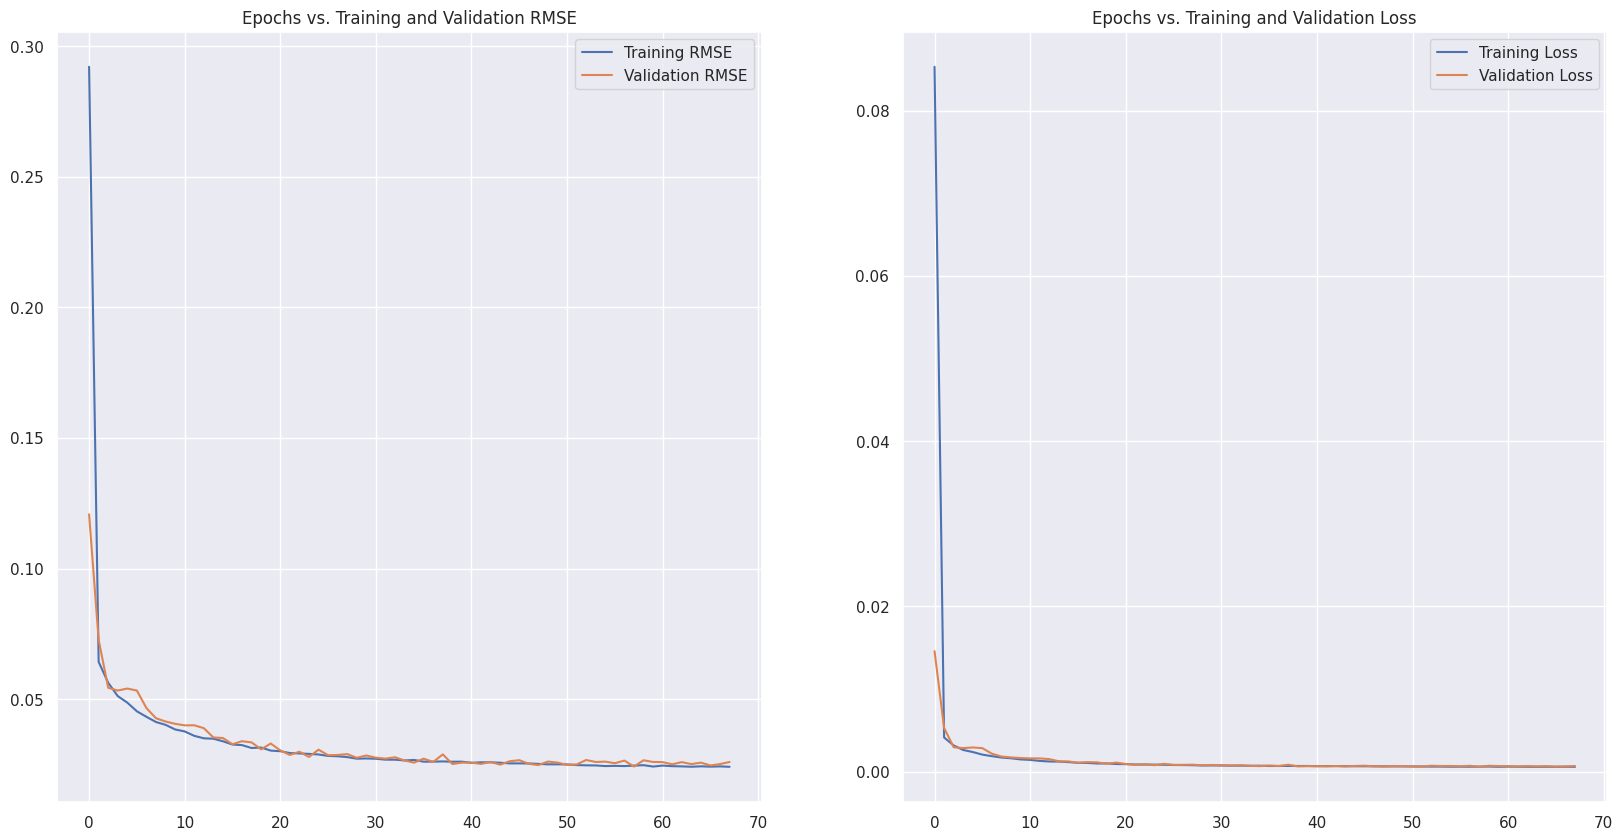

In [101]:
plot_model_rmse_and_loss(history)


In [102]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
RMSE of hour-ahead electricity price LSTM forecast: 2.397


**4.4. Stacked LSTM**

In [104]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape,
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3, amsgrad=True)
multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])


Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1087 - root_mean_squared_error: 0.2010

845/845 ━━━━━━━━━━━━━━━━━━━━ 134s 153ms/step - loss: 0.1086 - root_mean_squared_error: 0.2009 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0052 - root_mean_squared_error: 0.0717

845/845 ━━━━━━━━━━━━━━━━━━━━ 129s 153ms/step - loss: 0.0052 - root_mean_squared_error: 0.0717 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0667
Epoch 3/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 132s 142ms/step - loss: 0.0040 - root_mean_squared_error: 0.0627 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1439
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 116s 137ms/step - loss: 0.5504 - root_mean_squared_error: 0.6859 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 106s 125ms/step - loss: 0.0157 - root_mean_squared_error: 0.1249 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 104s 124ms/step - loss: 0.0158 - root_mean_squared_error: 0.1250 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1142
Epoch 7/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 104s 123ms/step - loss: 0.0156 - root_mean_squared_error: 0.1246 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 8/120
845/845 ━━━━━━━━━━━━━━

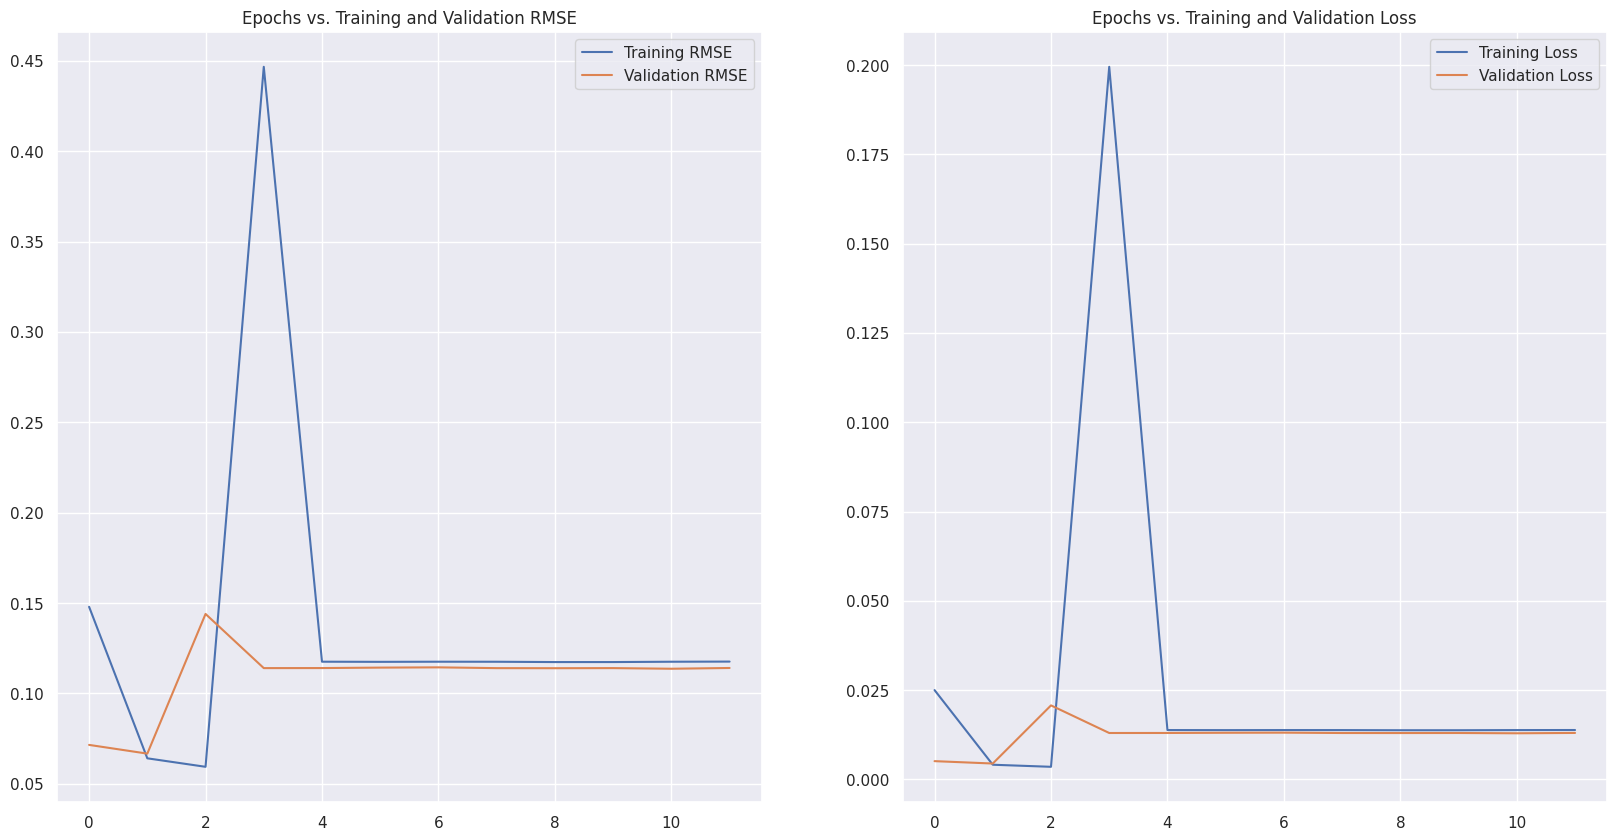

In [106]:
plot_model_rmse_and_loss(history)


In [107]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv,
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step
RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: 5.192


**4.5. CNN**

In [109]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)
multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [110]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping,
                                          model_checkpoint])


Epoch 1/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - root_mean_squared_error: 0.1472

845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0528 - root_mean_squared_error: 0.1470 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 2/120
840/845 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0472

845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0472 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 3/120
838/845 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357

845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316

845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.8626e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 6/120
839/845 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3225e-04 - root_mean_squared_error: 0.0287

845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.3096e-04 - root_mean_squared_error: 0.0287 - val_loss: 9.9670e-04 - val_root_mean_squared_error: 0.0316
Epoch 7/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8189e-04 - root_mean_squared_error: 0.0278

845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.8151e-04 - root_mean_squared_error: 0.0278 - val_loss: 6.6419e-04 - val_root_mean_squared_error: 0.0258
Epoch 8/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.0787e-04 - root_mean_squared_error: 0.0265 - val_loss: 9.6099e-04 - val_root_mean_squared_error: 0.0310
Epoch 9/120
841/845 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8081e-04 - root_mean_squared_error: 0.0260

845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6.8013e-04 - root_mean_squared_error: 0.0260 - val_loss: 6.5074e-04 - val_root_mean_squared_error: 0.0255
Epoch 10/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.8235e-04 - root_mean_squared_error: 0.0260 - val_loss: 6.9088e-04 - val_root_mean_squared_error: 0.0263
Epoch 11/120
839/845 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5826e-04 - root_mean_squared_error: 0.0256

845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 6.5745e-04 - root_mean_squared_error: 0.0255 - val_loss: 6.2344e-04 - val_root_mean_squared_error: 0.0250
Epoch 12/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6.4061e-04 - root_mean_squared_error: 0.0252 - val_loss: 6.4724e-04 - val_root_mean_squared_error: 0.0254
Epoch 13/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6.5195e-04 - root_mean_squared_error: 0.0254 - val_loss: 7.0008e-04 - val_root_mean_squared_error: 0.0265
Epoch 14/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3332e-04 - root_mean_squared_error: 0.0250

845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.3290e-04 - root_mean_squared_error: 0.0250 - val_loss: 6.0041e-04 - val_root_mean_squared_error: 0.0245
Epoch 15/120
830/845 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1301e-04 - root_mean_squared_error: 0.0247

845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.1111e-04 - root_mean_squared_error: 0.0246 - val_loss: 5.7383e-04 - val_root_mean_squared_error: 0.0240
Epoch 16/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.3414e-04 - root_mean_squared_error: 0.0251 - val_loss: 5.9491e-04 - val_root_mean_squared_error: 0.0244
Epoch 17/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.7822e-04 - root_mean_squared_error: 0.0240 - val_loss: 6.3910e-04 - val_root_mean_squared_error: 0.0253
Epoch 18/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.4751e-04 - root_mean_squared_error: 0.0252 - val_loss: 6.4059e-04 - val_root_mean_squared_error: 0.0253
Epoch 19/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6.1248e-04 - root_mean_squared_error: 0.0246 - val_loss: 6.4564e-04 - val_root_mean_squared_error: 0.0254
Epoch 20/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.7569e-04 - root_mean_squared_error: 0.0239 - val_loss: 8.3375e-04 - val_root_mean_squared_error: 0.0289
Epoch

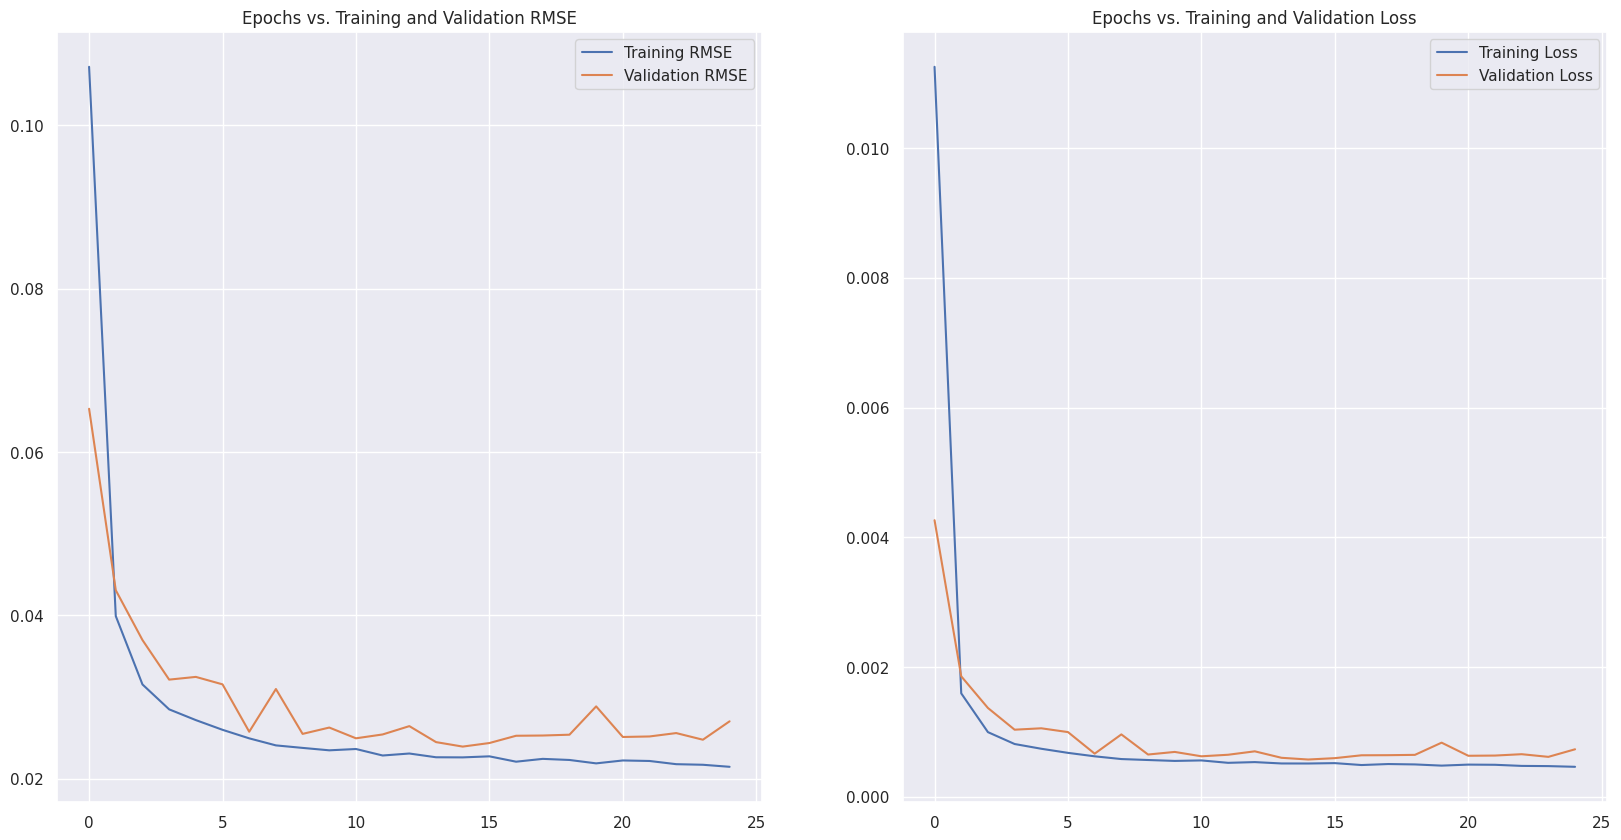

In [111]:
plot_model_rmse_and_loss(history)


In [112]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE of hour-ahead electricity price multivariate CNN forecast: 2.389


**4.6. CNN-LSTM**

In [113]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,metrics=metric)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [114]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping,
                                               model_checkpoint])

Epoch 1/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3881 - root_mean_squared_error: 0.3465

845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - loss: 0.3873 - root_mean_squared_error: 0.3462 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033 - root_mean_squared_error: 0.0563

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0033 - root_mean_squared_error: 0.0563 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 3/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - root_mean_squared_error: 0.0416

845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0018 - root_mean_squared_error: 0.0416 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 4/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364

845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 5/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 7/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 9.3842e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 8/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.5641e-04 - root_mean_squared_error: 0.0291

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 8.5600e-04 - root_mean_squared_error: 0.0291 - val_loss: 8.7240e-04 - val_root_mean_squared_error: 0.0295
Epoch 9/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 7.6134e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 10/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.7629e-04 - root_mean_squared_error: 0.0277

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.7612e-04 - root_mean_squared_error: 0.0277 - val_loss: 7.9441e-04 - val_root_mean_squared_error: 0.0282
Epoch 11/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.8865e-04 - root_mean_squared_error: 0.0261

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.8837e-04 - root_mean_squared_error: 0.0261 - val_loss: 5.8686e-04 - val_root_mean_squared_error: 0.0242
Epoch 12/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.1542e-04 - root_mean_squared_error: 0.0267

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.1527e-04 - root_mean_squared_error: 0.0266 - val_loss: 5.7291e-04 - val_root_mean_squared_error: 0.0239
Epoch 13/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.8434e-04 - root_mean_squared_error: 0.0261 - val_loss: 6.6848e-04 - val_root_mean_squared_error: 0.0259
Epoch 14/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 6.5493e-04 - root_mean_squared_error: 0.0255 - val_loss: 6.3978e-04 - val_root_mean_squared_error: 0.0253
Epoch 15/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.6206e-04 - root_mean_squared_error: 0.0256 - val_loss: 6.4034e-04 - val_root_mean_squared_error: 0.0253
Epoch 16/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 6.5229e-04 - root_mean_squared_error: 0.0254 - val_loss: 5.9729e-04 - val_root_mean_squared_error: 0.0244
Epoch 17/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 6.3099e-04 - root_mean_squared_error: 0.0250 - val_loss: 6.9122e-04 - val_root_mean_squared_error: 

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.5035e-04 - root_mean_squared_error: 0.0254 - val_loss: 5.6492e-04 - val_root_mean_squared_error: 0.0238
Epoch 20/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.2538e-04 - root_mean_squared_error: 0.0249 - val_loss: 6.6011e-04 - val_root_mean_squared_error: 0.0257
Epoch 21/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 5.9774e-04 - root_mean_squared_error: 0.0244 - val_loss: 5.9059e-04 - val_root_mean_squared_error: 0.0243
Epoch 22/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 6.2008e-04 - root_mean_squared_error: 0.0248 - val_loss: 6.5755e-04 - val_root_mean_squared_error: 0.0256
Epoch 23/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.0399e-04 - root_mean_squared_error: 0.0244

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 6.0360e-04 - root_mean_squared_error: 0.0244 - val_loss: 5.5239e-04 - val_root_mean_squared_error: 0.0235
Epoch 24/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 5.8543e-04 - root_mean_squared_error: 0.0241 - val_loss: 6.5602e-04 - val_root_mean_squared_error: 0.0256
Epoch 25/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 5.8821e-04 - root_mean_squared_error: 0.0242 - val_loss: 5.5753e-04 - val_root_mean_squared_error: 0.0236
Epoch 26/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 6.0265e-04 - root_mean_squared_error: 0.0244 - val_loss: 9.1676e-04 - val_root_mean_squared_error: 0.0303
Epoch 27/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3091e-04 - root_mean_squared_error: 0.0249

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.3059e-04 - root_mean_squared_error: 0.0249 - val_loss: 5.3117e-04 - val_root_mean_squared_error: 0.0230
Epoch 28/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 5.9275e-04 - root_mean_squared_error: 0.0242 - val_loss: 7.1892e-04 - val_root_mean_squared_error: 0.0268
Epoch 29/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 5.7737e-04 - root_mean_squared_error: 0.0239 - val_loss: 5.7407e-04 - val_root_mean_squared_error: 0.0240
Epoch 30/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 5.5401e-04 - root_mean_squared_error: 0.0235 - val_loss: 6.6403e-04 - val_root_mean_squared_error: 0.0258
Epoch 31/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 5.7660e-04 - root_mean_squared_error: 0.0239 - val_loss: 5.6908e-04 - val_root_mean_squared_error: 0.0239
Epoch 32/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 5.5081e-04 - root_mean_squared_error: 0.0234 - val_loss: 7.2412e-04 - val_root_mean_squared_error: 

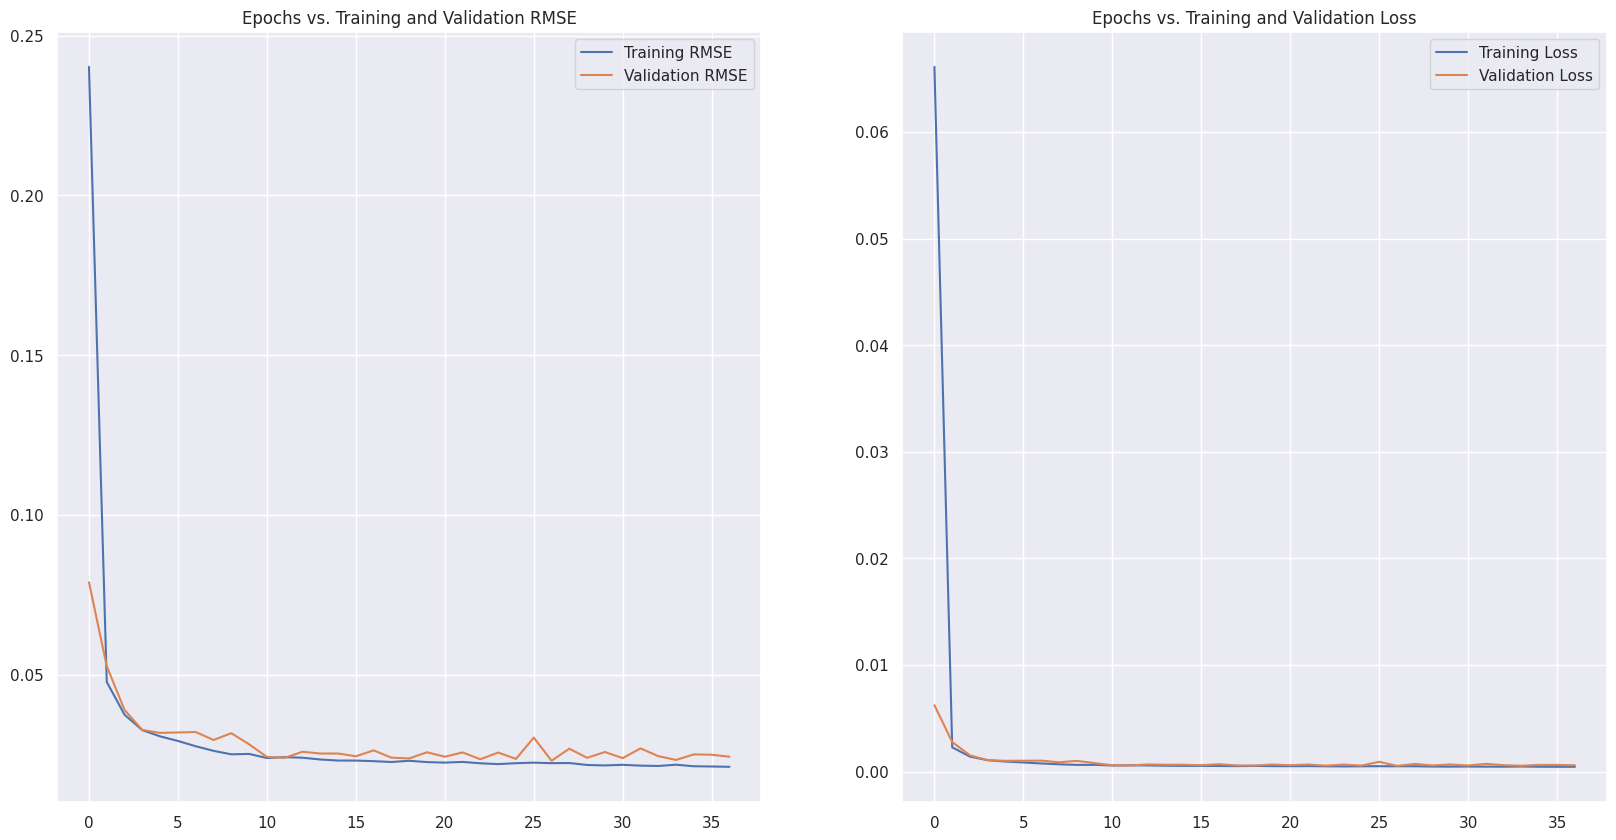

In [115]:
plot_model_rmse_and_loss(history)


In [116]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv,
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: 2.218


In [117]:
X_test.shape


(3984, 24, 19)

**4.7. Time Distributed MLP**

In [119]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)
multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,metrics=metric)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [120]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping,
                                          model_checkpoint])


Epoch 1/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0469 - root_mean_squared_error: 0.1300

845/845 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - loss: 0.0468 - root_mean_squared_error: 0.1299 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0545
Epoch 2/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485

845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 3/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419

845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 9.7403e-04 - val_root_mean_squared_error: 0.0312
Epoch 4/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355

845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 7.8432e-04 - val_root_mean_squared_error: 0.0280
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 9.2222e-04 - val_root_mean_squared_error: 0.0304
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 8.2147e-04 - val_root_mean_squared_error: 0.0287
Epoch 7/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 9.7104e-04 - root_mean_squared_error: 0.0311 - val_loss: 8.0286e-04 - val_root_mean_squared_error: 0.0283
Epoch 8/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.5336e-04 - root_mean_squared_error: 0.0308

845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 9.5301e-04 - root_mean_squared_error: 0.0307 - val_loss: 6.8369e-04 - val_root_mean_squared_error: 0.0261
Epoch 9/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 9.2401e-04 - root_mean_squared_error: 0.0303 - val_loss: 8.5725e-04 - val_root_mean_squared_error: 0.0293
Epoch 10/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.8813e-04 - root_mean_squared_error: 0.0297

845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 8.8767e-04 - root_mean_squared_error: 0.0297 - val_loss: 6.3268e-04 - val_root_mean_squared_error: 0.0252
Epoch 11/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 9.2813e-04 - root_mean_squared_error: 0.0303 - val_loss: 8.9106e-04 - val_root_mean_squared_error: 0.0299
Epoch 12/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 8.9322e-04 - root_mean_squared_error: 0.0298 - val_loss: 6.8373e-04 - val_root_mean_squared_error: 0.0261
Epoch 13/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 8.7773e-04 - root_mean_squared_error: 0.0295 - val_loss: 7.2637e-04 - val_root_mean_squared_error: 0.0270
Epoch 14/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 8.3221e-04 - root_mean_squared_error: 0.0288 - val_loss: 6.3363e-04 - val_root_mean_squared_error: 0.0252
Epoch 15/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 8.4604e-04 - root_mean_squared_error: 0.0290 - val_loss: 6.5325e-04 - val_root_mean_squared_error: 

845/845 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 8.2001e-04 - root_mean_squared_error: 0.0286 - val_loss: 5.6507e-04 - val_root_mean_squared_error: 0.0238
Epoch 19/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 7.7619e-04 - root_mean_squared_error: 0.0278 - val_loss: 6.5265e-04 - val_root_mean_squared_error: 0.0255
Epoch 20/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 7.8832e-04 - root_mean_squared_error: 0.0280 - val_loss: 7.6600e-04 - val_root_mean_squared_error: 0.0277
Epoch 21/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - loss: 7.7377e-04 - root_mean_squared_error: 0.0277 - val_loss: 6.5285e-04 - val_root_mean_squared_error: 0.0256
Epoch 22/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 7.4422e-04 - root_mean_squared_error: 0.0272 - val_loss: 6.4003e-04 - val_root_mean_squared_error: 0.0253
Epoch 23/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 7.4901e-04 - root_mean_squared_error: 0.0273 - val_loss: 6.2033e-04 - val_root_mean_squared_error: 

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 6.8996e-04 - root_mean_squared_error: 0.0262 - val_loss: 5.6050e-04 - val_root_mean_squared_error: 0.0237
Epoch 29/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - loss: 7.0415e-04 - root_mean_squared_error: 0.0265 - val_loss: 7.7462e-04 - val_root_mean_squared_error: 0.0278
Epoch 30/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 6.9489e-04 - root_mean_squared_error: 0.0263 - val_loss: 6.7624e-04 - val_root_mean_squared_error: 0.0260
Epoch 31/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 7.1789e-04 - root_mean_squared_error: 0.0267 - val_loss: 7.0039e-04 - val_root_mean_squared_error: 0.0265
Epoch 32/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 6.8256e-04 - root_mean_squared_error: 0.0261 - val_loss: 6.4181e-04 - val_root_mean_squared_error: 0.0253
Epoch 33/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 6.7173e-04 - root_mean_squared_error: 0.0258 - val_loss: 6.4469e-04 - val_root_mean_squared_error: 

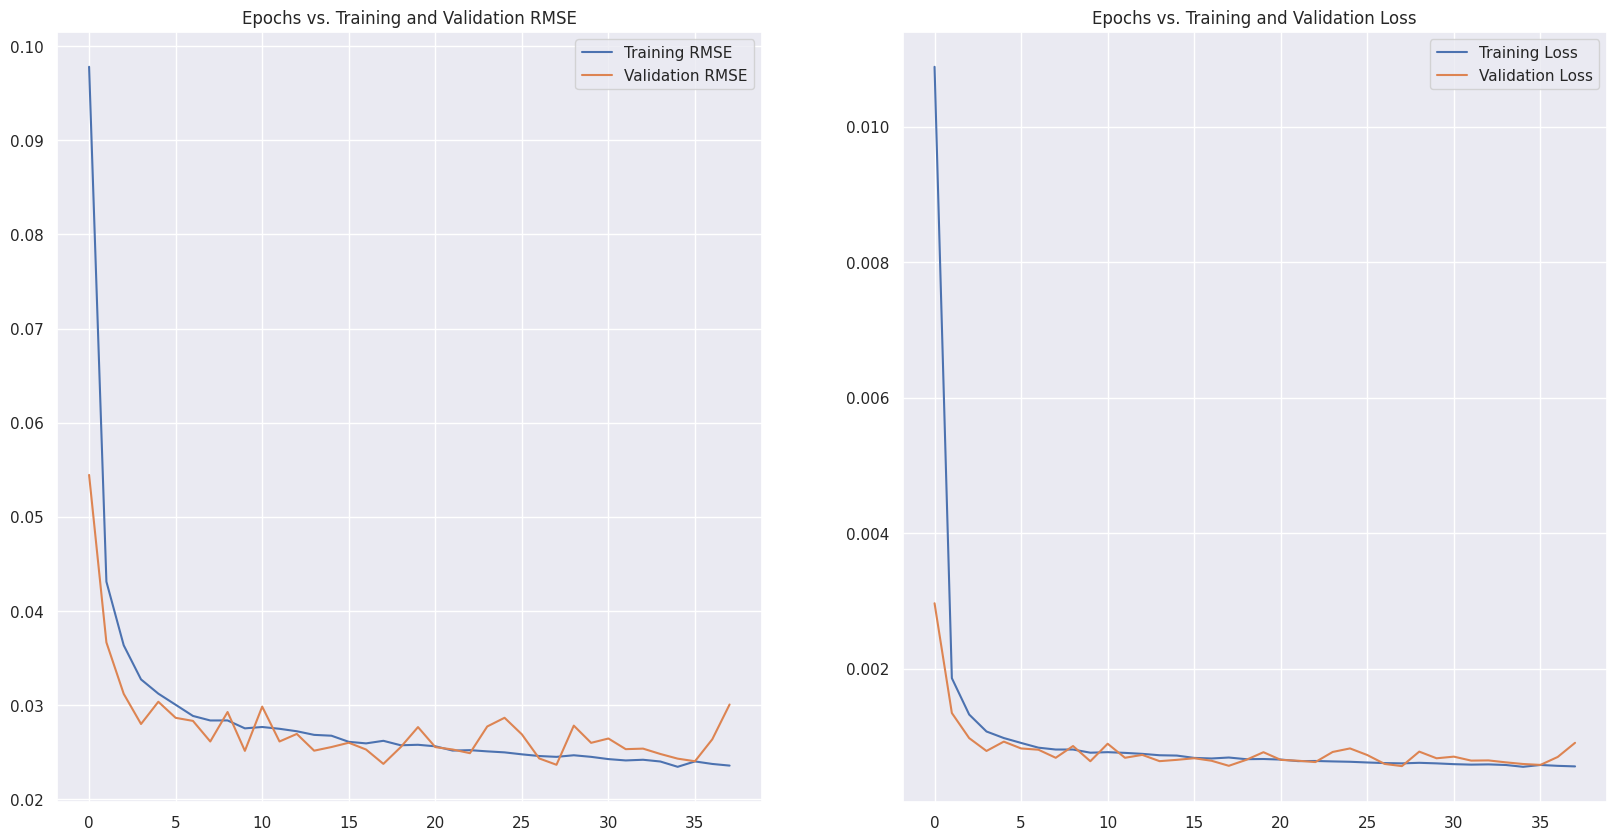

In [121]:
plot_model_rmse_and_loss(history)


In [122]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
RMSE of hour-ahead electricity price multivariate MLP forecast: 2.28


**4.8. Encoder-Decoder**

In [123]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,optimizer=optimizer,
                    metrics=metric)
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping,
                                         model_checkpoint])



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0129 - root_mean_squared_error: 0.0789

845/845 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.0129 - root_mean_squared_error: 0.0788 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 2/50
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0023 - root_mean_squared_error: 0.0470

845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 0.0023 - root_mean_squared_error: 0.0469 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 6/50
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.5533e-04 - root_mean_squared_error: 0.0307

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 9.5470e-04 - root_mean_squared_error: 0.0307 - val_loss: 7.4038e-04 - val_root_mean_squared_error: 0.0272
Epoch 7/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.6050e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 8/50
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.4488e-04 - root_mean_squared_error: 0.0289

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.4447e-04 - root_mean_squared_error: 0.0289 - val_loss: 6.8564e-04 - val_root_mean_squared_error: 0.0262
Epoch 9/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 7.7474e-04 - root_mean_squared_error: 0.0277 - val_loss: 7.6261e-04 - val_root_mean_squared_error: 0.0276
Epoch 10/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.0630e-04 - root_mean_squared_error: 0.0265 - val_loss: 8.0272e-04 - val_root_mean_squared_error: 0.0283
Epoch 11/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 6.7684e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 12/50
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.9297e-04 - root_mean_squared_error: 0.0262

845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 6.9265e-04 - root_mean_squared_error: 0.0262 - val_loss: 5.8670e-04 - val_root_mean_squared_error: 0.0242
Epoch 13/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 6.8129e-04 - root_mean_squared_error: 0.0260 - val_loss: 6.0746e-04 - val_root_mean_squared_error: 0.0246
Epoch 14/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.5575e-04 - root_mean_squared_error: 0.0255 - val_loss: 7.3031e-04 - val_root_mean_squared_error: 0.0270
Epoch 15/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.2199e-04 - root_mean_squared_error: 0.0249 - val_loss: 9.5986e-04 - val_root_mean_squared_error: 0.0310
Epoch 16/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 6.3637e-04 - root_mean_squared_error: 0.0251 - val_loss: 6.5933e-04 - val_root_mean_squared_error: 0.0257
Epoch 17/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.3369e-04 - root_mean_squared_error: 0.0251 - val_loss: 8.1872e-04 - val_root_mean_squared_error: 0.028

845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.0529e-04 - root_mean_squared_error: 0.0245 - val_loss: 5.4172e-04 - val_root_mean_squared_error: 0.0233
Epoch 20/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 5.9360e-04 - root_mean_squared_error: 0.0243 - val_loss: 6.3416e-04 - val_root_mean_squared_error: 0.0252
Epoch 21/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 5.8592e-04 - root_mean_squared_error: 0.0241 - val_loss: 7.8920e-04 - val_root_mean_squared_error: 0.0281
Epoch 22/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 5.7544e-04 - root_mean_squared_error: 0.0239 - val_loss: 9.0665e-04 - val_root_mean_squared_error: 0.0301
Epoch 23/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 5.8549e-04 - root_mean_squared_error: 0.0241 - val_loss: 5.9278e-04 - val_root_mean_squared_error: 0.0243
Epoch 24/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 5.7054e-04 - root_mean_squared_error: 0.0238 - val_loss: 6.4039e-04 - val_root_mean_squared_error: 0.025

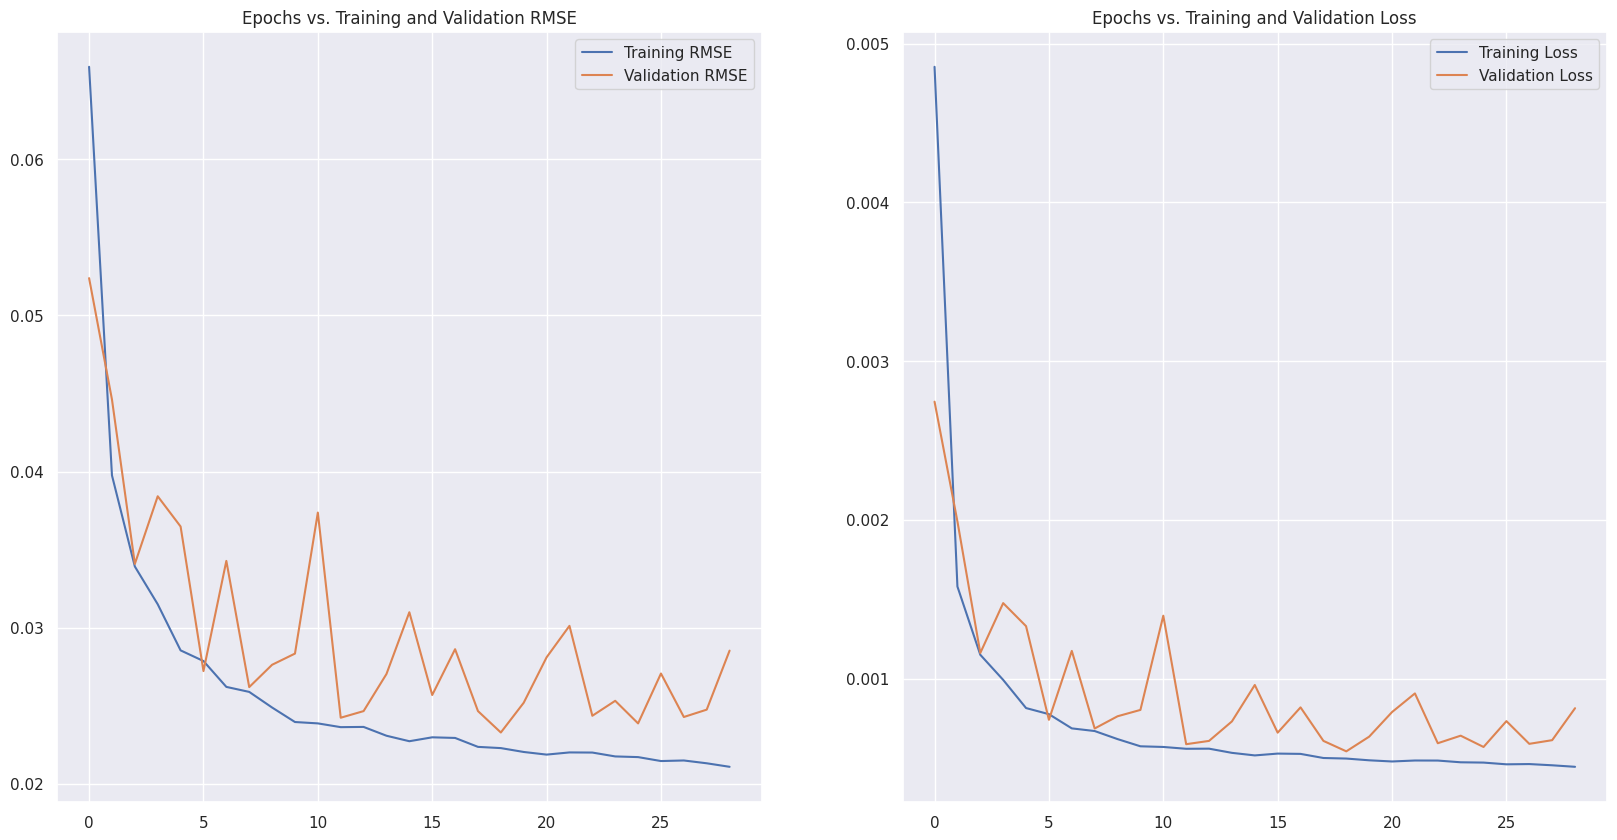

In [124]:
plot_model_rmse_and_loss(history)


In [125]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv,
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
RMSE of hour-ahead electricity price Encoder-Decoder forecast: 2.204
